In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mols2grid
import base64
import io
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold
from IPython.display import HTML
#from espsim import EmbedAlignConstrainedScore, EmbedAlignScore, ConstrainedEmbedMultipleConfs, GetEspSim

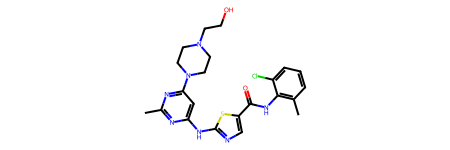

In [2]:
im = "CC1=C(C(=CC=C1)Cl)NC(=O)C2=CN=C(S2)NC3=CC(=NC(=N3)C)N4CCN(CC4)CCO"
mol = Chem.MolFromSmiles(im)
mol

## Decompose molecule into rings with wildcard atoms

RING FRAGMENTS

Ring 1 (fused_ring):
  Base SMILES:     COc1cccc2c1CCCC2
  Wildcard SMILES: COc1cccc2c1CCC[C@H]2[*:1]
  RDKit readable:  True
  Size: 10, Heteroatoms: 1
  Attachment atoms: [11]

Ring 2 (fused_ring):
  Base SMILES:     c1ccc2c(c1)CCN2
  Wildcard SMILES: c1cc2c(cc1[*:2])N([*:3])CC2
  RDKit readable:  True
  Size: 9, Heteroatoms: 1
  Attachment atoms: [17, 23]

NON-RING FRAGMENTS

Fragment 1 (linker):
  Base SMILES:     CCN(C)C
  Wildcard SMILES: CN(CC[*:2])C[*:1]
  RDKit readable:  True
  Size: 5, Heteroatoms: 1
  Attachment atoms: [12, 16]

Fragment 2 (terminal):
  Base SMILES:     CS(=O)=O
  Wildcard SMILES: CS(=O)(=O)[*:3]
  RDKit readable:  True
  Size: 4, Heteroatoms: 3
  Attachment atoms: [24]

VISUALIZATION


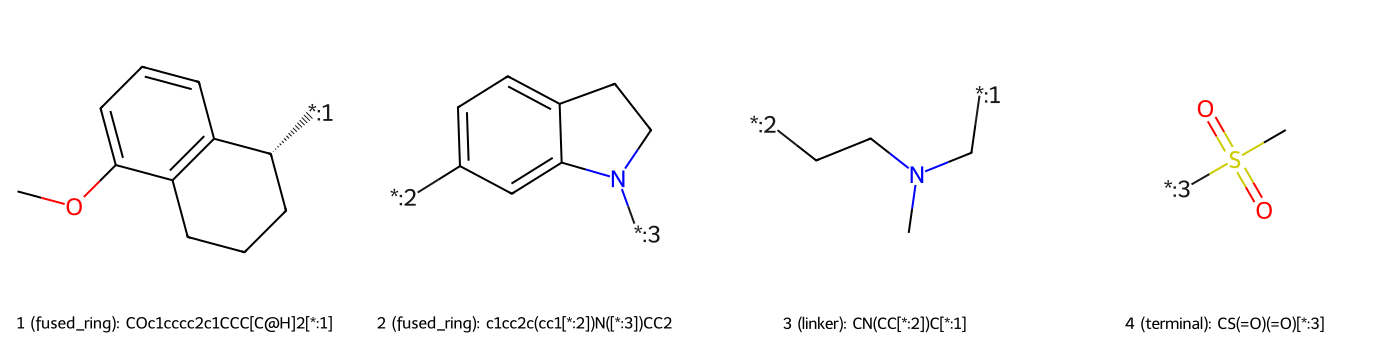

In [25]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from typing import List, Dict, Set, Tuple
from IPython.display import display

def decompose_molecule_with_wildcards(mol: Chem.Mol, include_terminal_substituents: bool = True, 
                                       preserve_fused_rings: bool = True,
                                       max_terminal_atoms: int = 3) -> Dict[str, List[Dict]]:
    """
    Decompose a molecule into its individual rings (or fused ring systems) AND non-ring fragments,
    adding numbered wildcard dummy atoms ([*:1], [*:2], etc.) at each attachment point.
    
    Connected fragments will have matching dummy atom numbers indicating which pieces
    connect to each other.
    
    Terminal substituents (e.g., methyl groups, ethyl groups) that are only attached to the ring
    and not to any other functional groups can optionally be included as part of the ring,
    up to a specified number of heavy atoms.
    
    Fused/bicyclic ring systems can be preserved as single units.

    Args:
        mol: RDKit Mol object
        include_terminal_substituents: If True, include terminal groups as part of the ring
        preserve_fused_rings: If True, keep fused/bicyclic rings together as single units
        max_terminal_atoms: Maximum number of heavy atoms in terminal substituents to include (default: 3)

    Returns:
        Dict with two keys:
            - 'rings': List of ring fragment dicts
            - 'non_rings': List of non-ring fragment dicts
        
        Each dict contains:
            - 'base_smiles': SMILES of the fragment without wildcards
            - 'wildcard_smiles': SMILES with numbered [*:n] at attachment points (RDKit-readable)
            - 'frag_mol': RDKit Mol of the fragment with wildcards (for depiction)
            - 'atom_indices': tuple of atom indices in parent molecule
            - 'attachment_atoms': list of parent atom indices that are attachment points
            - 'size': number of heavy atoms (excluding wildcards)
            - 'hetero_count': number of heteroatoms
            - 'frag_type': 'ring', 'fused_ring', 'linker', 'terminal', etc.
    """
    if mol is None:
        return {'rings': [], 'non_rings': []}

    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    
    # Get all atoms that are part of any ring
    all_ring_atoms = set()
    for ring in atom_rings:
        all_ring_atoms.update(ring)
    
    # ============== PART 1: Process Ring Systems ==============
    
    # Group fused rings together if requested
    if preserve_fused_rings and atom_rings:
        ring_sets = [set(ring) for ring in atom_rings]
        
        merged = True
        while merged:
            merged = False
            new_ring_sets = []
            used = [False] * len(ring_sets)
            
            for i in range(len(ring_sets)):
                if used[i]:
                    continue
                current = ring_sets[i].copy()
                used[i] = True
                
                for j in range(i + 1, len(ring_sets)):
                    if used[j]:
                        continue
                    if current & ring_sets[j]:
                        current |= ring_sets[j]
                        used[j] = True
                        merged = True
                
                new_ring_sets.append(current)
            
            ring_sets = new_ring_sets
        
        ring_systems = [tuple(sorted(rs)) for rs in ring_sets]
    else:
        ring_systems = [tuple(ring) for ring in atom_rings] if atom_rings else []
    
    # First pass: collect all fragments and their atoms
    all_fragments = []  # List of (frag_type_category, ring_system_or_none, atom_set, is_fused)
    atoms_assigned_to_rings = set()

    for ring_system in ring_systems:
        ring_atoms = set(ring_system)
        is_fused = preserve_fused_rings and len(ring_system) > 6
        
        # Expand ring atoms to include terminal substituents if requested
        if include_terminal_substituents:
            expanded_atoms = set(ring_atoms)
            
            def get_terminal_chain(start_idx: int, from_atoms: Set[int], max_atoms: int) -> Set[int]:
                """
                Find a terminal chain starting from start_idx that:
                1. Does not connect to any ring atoms (other than through from_atoms)
                2. Does not branch into chains longer than max_atoms
                3. Has at most max_atoms heavy atoms total
                
                Returns set of atom indices in the terminal chain, or empty set if not terminal.
                """
                if start_idx in all_ring_atoms:
                    return set()
                
                # BFS to collect the entire connected component of non-ring atoms
                # reachable from start_idx without going through from_atoms
                chain = set()
                queue = [start_idx]
                visited = set(from_atoms)  # Don't revisit atoms we came from
                
                while queue:
                    current = queue.pop(0)
                    if current in visited:
                        continue
                    if current in all_ring_atoms:
                        # This chain connects to another ring - not terminal
                        return set()
                    
                    visited.add(current)
                    chain.add(current)
                    
                    # Check if we've exceeded max atoms
                    if len(chain) > max_atoms:
                        return set()
                    
                    atom = mol.GetAtomWithIdx(current)
                    for neighbor in atom.GetNeighbors():
                        nb_idx = neighbor.GetIdx()
                        if nb_idx not in visited:
                            queue.append(nb_idx)
                
                # Verify the chain is truly terminal (only connects back to from_atoms, not to other rings)
                for atom_idx in chain:
                    atom = mol.GetAtomWithIdx(atom_idx)
                    for neighbor in atom.GetNeighbors():
                        nb_idx = neighbor.GetIdx()
                        if nb_idx not in chain and nb_idx not in from_atoms:
                            # Connected to something outside the chain and not the ring
                            if nb_idx in all_ring_atoms:
                                return set()  # Connects to another ring
                
                return chain
            
            # Check each atom adjacent to the ring for terminal substituents
            for ring_atom_idx in list(ring_atoms):
                atom = mol.GetAtomWithIdx(ring_atom_idx)
                for neighbor in atom.GetNeighbors():
                    nb_idx = neighbor.GetIdx()
                    if nb_idx in expanded_atoms:
                        continue
                    if nb_idx in all_ring_atoms:
                        continue
                    
                    # Try to get terminal chain starting from this neighbor
                    terminal_chain = get_terminal_chain(nb_idx, expanded_atoms, max_terminal_atoms)
                    if terminal_chain:
                        expanded_atoms.update(terminal_chain)
            
            ring_atoms_list = list(expanded_atoms)
        else:
            ring_atoms_list = list(ring_atoms)
        
        atoms_assigned_to_rings.update(ring_atoms_list)
        all_fragments.append(('ring', ring_system, set(ring_atoms_list), is_fused))
    
    # Get non-ring atoms
    all_atoms = set(range(mol.GetNumAtoms()))
    non_ring_atoms = all_atoms - atoms_assigned_to_rings
    
    # Find connected components among non-ring atoms
    if non_ring_atoms:
        visited = set()
        
        for start_atom in non_ring_atoms:
            if start_atom in visited:
                continue
            
            component = set()
            queue = [start_atom]
            
            while queue:
                current = queue.pop(0)
                if current in visited:
                    continue
                if current not in non_ring_atoms:
                    continue
                    
                visited.add(current)
                component.add(current)
                
                atom = mol.GetAtomWithIdx(current)
                for neighbor in atom.GetNeighbors():
                    nb_idx = neighbor.GetIdx()
                    if nb_idx in non_ring_atoms and nb_idx not in visited:
                        queue.append(nb_idx)
            
            if component:
                all_fragments.append(('non_ring', None, component, False))
    
    # ============== Build Bond-to-Number Mapping ==============
    # Find all bonds between different fragments and assign numbers
    
    bond_number_map = {}  # (atom1_idx, atom2_idx) -> number (with atom1 < atom2)
    current_bond_number = 1
    
    for i, (cat1, rs1, atoms1, _) in enumerate(all_fragments):
        for j, (cat2, rs2, atoms2, _) in enumerate(all_fragments):
            if i >= j:
                continue
            
            # Find bonds between fragment i and fragment j
            for a1 in atoms1:
                atom = mol.GetAtomWithIdx(a1)
                for neighbor in atom.GetNeighbors():
                    a2 = neighbor.GetIdx()
                    if a2 in atoms2:
                        bond_key = (min(a1, a2), max(a1, a2))
                        if bond_key not in bond_number_map:
                            bond_number_map[bond_key] = current_bond_number
                            current_bond_number += 1
    
    # ============== Process Each Fragment with Numbered Dummies ==============
    
    def process_fragment(atom_set: Set[int], frag_category: str, ring_system: Tuple = None, 
                        is_fused: bool = False) -> Dict:
        """Process a single fragment and return its info dict with numbered dummy atoms."""
        atom_list = list(atom_set)
        
        # Identify attachment bonds and their numbers
        attachment_info = []  # List of (internal_atom, external_atom, bond_number)
        for a_idx in atom_list:
            atom = mol.GetAtomWithIdx(a_idx)
            for neighbor in atom.GetNeighbors():
                nb_idx = neighbor.GetIdx()
                if nb_idx not in atom_set:
                    bond_key = (min(a_idx, nb_idx), max(a_idx, nb_idx))
                    bond_num = bond_number_map.get(bond_key, 0)
                    attachment_info.append((a_idx, nb_idx, bond_num))
        
        attachment_atoms = sorted(set(a for a, _, _ in attachment_info))
        
        # Determine fragment type for non-rings
        if frag_category == 'non_ring':
            if len(attachment_atoms) == 0:
                frag_type = 'isolated'
            elif len(attachment_atoms) == 1:
                frag_type = 'terminal'
            else:
                frag_type = 'linker'
        else:
            frag_type = 'fused_ring' if is_fused else 'ring'
        
        base_smi = Chem.MolFragmentToSmiles(mol, atom_list, canonical=True)
        
        # Get bonds to break with their dummy labels
        bonds_to_break = []
        dummy_labels = []  # List of (bond_idx, (label_for_begin, label_for_end))
        
        for a_idx, nb_idx, bond_num in attachment_info:
            bond = mol.GetBondBetweenAtoms(a_idx, nb_idx)
            if bond is not None:
                bond_idx = bond.GetIdx()
                if bond_idx not in [b for b, _ in dummy_labels]:
                    # Determine which end is inside our fragment
                    begin_idx = bond.GetBeginAtomIdx()
                    end_idx = bond.GetEndAtomIdx()
                    
                    if begin_idx in atom_set:
                        # Begin is inside, end is outside
                        # The dummy attached to begin gets the label
                        dummy_labels.append((bond_idx, (bond_num, bond_num)))
                    else:
                        # End is inside, begin is outside
                        dummy_labels.append((bond_idx, (bond_num, bond_num)))
                    
                    bonds_to_break.append(bond_idx)
        
        frag_mol = None
        wildcard_smi = None
        
        if bonds_to_break:
            try:
                # Create dummy labels list in bond order
                dummy_label_list = []
                for bond_idx in bonds_to_break:
                    for bi, (l1, l2) in dummy_labels:
                        if bi == bond_idx:
                            dummy_label_list.append((l1, l2))
                            break
                
                frag_mol_temp = Chem.FragmentOnBonds(mol, bonds_to_break, addDummies=True, 
                                                      dummyLabels=dummy_label_list)
                frags = Chem.GetMolFrags(frag_mol_temp, asMols=True, sanitizeFrags=False)
                frag_atom_lists = Chem.GetMolFrags(frag_mol_temp, asMols=False)
                
                target_frag = None
                for frag, frag_atoms in zip(frags, frag_atom_lists):
                    frag_atoms_set = set(frag_atoms)
                    
                    # Check if this fragment contains atoms from our atom_set
                    check_atoms = ring_system if ring_system else atom_list
                    if any(a_idx in frag_atoms_set for a_idx in check_atoms):
                        non_dummy_count = sum(1 for a in frag.GetAtoms() if a.GetAtomicNum() != 0)
                        if non_dummy_count == len(atom_list):
                            target_frag = frag
                            break
                
                if target_frag is not None:
                    frag_mol = target_frag
                    
                    # Convert isotope labels to atom map numbers for [*:n] format
                    rw = Chem.RWMol(frag_mol)
                    for atom in rw.GetAtoms():
                        if atom.GetAtomicNum() == 0:
                            isotope = atom.GetIsotope()
                            if isotope > 0:
                                atom.SetAtomMapNum(isotope)
                            atom.SetIsotope(0)
                    frag_mol = rw.GetMol()
                    
                    try:
                        Chem.SanitizeMol(frag_mol)
                    except:
                        try:
                            for atom in frag_mol.GetAtoms():
                                atom.SetIsAromatic(False)
                            for bond in frag_mol.GetBonds():
                                bond.SetIsAromatic(False)
                            Chem.SanitizeMol(frag_mol)
                        except:
                            frag_mol = None
            except Exception as e:
                frag_mol = None
        
        if frag_mol is None:
            try:
                frag_mol = Chem.MolFromSmiles(base_smi)
                wildcard_smi = base_smi
            except:
                return None
        
        if frag_mol is None:
            return None

        try:
            rdDepictor.Compute2DCoords(frag_mol)
        except:
            pass

        if wildcard_smi is None:
            try:
                wildcard_smi = Chem.MolToSmiles(frag_mol, canonical=True)
            except:
                wildcard_smi = base_smi
        
        test_mol = Chem.MolFromSmiles(wildcard_smi)
        if test_mol is None:
            wildcard_smi = base_smi

        hetero_count = sum(
            1 for a in frag_mol.GetAtoms()
            if a.GetAtomicNum() not in (0, 1, 6)
        )
        
        result = {
            'base_smiles': base_smi,
            'wildcard_smiles': wildcard_smi,
            'frag_mol': frag_mol,
            'atom_indices': tuple(atom_list),
            'attachment_atoms': attachment_atoms,
            'size': len(ring_system) if ring_system else len(atom_list),
            'hetero_count': hetero_count,
            'frag_type': frag_type
        }
        
        if ring_system:
            result['core_ring_atoms'] = ring_system
            result['total_atoms'] = len(atom_list)
        
        return result
    
    # Process all fragments
    ring_results = []
    non_ring_results = []
    seen_wildcard_smiles = set()
    
    for cat, ring_sys, atoms, is_fused in all_fragments:
        result = process_fragment(atoms, cat, ring_sys, is_fused)
        if result is None:
            continue
        
        if result['wildcard_smiles'] in seen_wildcard_smiles:
            continue
        seen_wildcard_smiles.add(result['wildcard_smiles'])
        
        if cat == 'ring':
            ring_results.append(result)
        else:
            non_ring_results.append(result)

    return {'rings': ring_results, 'non_rings': non_ring_results}


# Keep the old function name as an alias for backward compatibility
def decompose_rings_with_wildcards(mol: Chem.Mol, include_terminal_substituents: bool = True, 
                                    preserve_fused_rings: bool = True) -> List[Dict]:
    """Backward compatible wrapper - returns only rings."""
    result = decompose_molecule_with_wildcards(mol, include_terminal_substituents, preserve_fused_rings)
    return result['rings']


# Example usage with the query molecule
decomposition = decompose_molecule_with_wildcards(mol, include_terminal_substituents=True, preserve_fused_rings=True, max_terminal_atoms=3)

print("=" * 60)
print("RING FRAGMENTS")
print("=" * 60)
for i, frag in enumerate(decomposition['rings'], start=1):
    print(f"\nRing {i} ({frag['frag_type']}):")
    print(f"  Base SMILES:     {frag['base_smiles']}")
    print(f"  Wildcard SMILES: {frag['wildcard_smiles']}")
    test = Chem.MolFromSmiles(frag['wildcard_smiles'])
    print(f"  RDKit readable:  {test is not None}")
    print(f"  Size: {frag['size']}, Heteroatoms: {frag['hetero_count']}")
    print(f"  Attachment atoms: {frag['attachment_atoms']}")

print("\n" + "=" * 60)
print("NON-RING FRAGMENTS")
print("=" * 60)
for i, frag in enumerate(decomposition['non_rings'], start=1):
    print(f"\nFragment {i} ({frag['frag_type']}):")
    print(f"  Base SMILES:     {frag['base_smiles']}")
    print(f"  Wildcard SMILES: {frag['wildcard_smiles']}")
    test = Chem.MolFromSmiles(frag['wildcard_smiles'])
    print(f"  RDKit readable:  {test is not None}")
    print(f"  Size: {frag['size']}, Heteroatoms: {frag['hetero_count']}")
    print(f"  Attachment atoms: {frag['attachment_atoms']}")

# Visualize all fragments
print("\n" + "=" * 60)
print("VISUALIZATION")
print("=" * 60)

all_frags = decomposition['rings'] + decomposition['non_rings']
#print(f"all_frags: {all_frags}")
if all_frags:
    mols = [f['frag_mol'] for f in all_frags]
    legends = []
    for i, f in enumerate(all_frags):
        ftype = f['frag_type']
        legends.append(f"{i+1} ({ftype}): {f['wildcard_smiles']}")
    
    grid = Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(350, 350))
    display(grid)

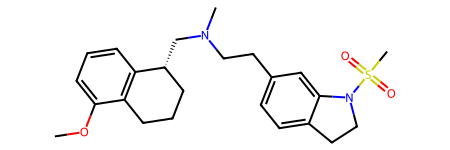

In [26]:
mol

# Testing molecule SMILES

RING FRAGMENTS

Ring 1 (fused_ring):
  Base SMILES:     COc1ccc2cncnc2c1
  Wildcard SMILES: COc1cc2ncnc([*:2])c2cc1[*:1]
  RDKit readable:  True
  Size: 10, Heteroatoms: 3
  Attachment atoms: [8, 11]

Ring 2 (ring):
  Base SMILES:     C1COCCN1
  Wildcard SMILES: C1CN([*:3])CCO1
  RDKit readable:  True
  Size: 6, Heteroatoms: 2
  Attachment atoms: [16]

Ring 3 (ring):
  Base SMILES:     Fc1ccccc1Cl
  Wildcard SMILES: Fc1ccc([*:4])cc1Cl
  RDKit readable:  True
  Size: 6, Heteroatoms: 2
  Attachment atoms: [23]

NON-RING FRAGMENTS

Fragment 1 (linker):
  Base SMILES:     CCCO
  Wildcard SMILES: C(CO[*:1])C[*:3]
  RDKit readable:  True
  Size: 4, Heteroatoms: 1
  Attachment atoms: [12, 15]

Fragment 2 (terminal):
  Base SMILES:     N
  Wildcard SMILES: N([*:2])[*:4]
  RDKit readable:  True
  Size: 1, Heteroatoms: 1
  Attachment atoms: [22]

VISUALIZATION


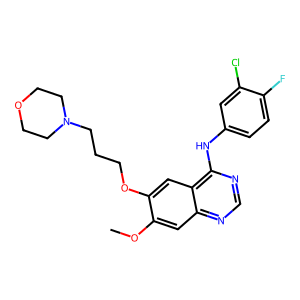

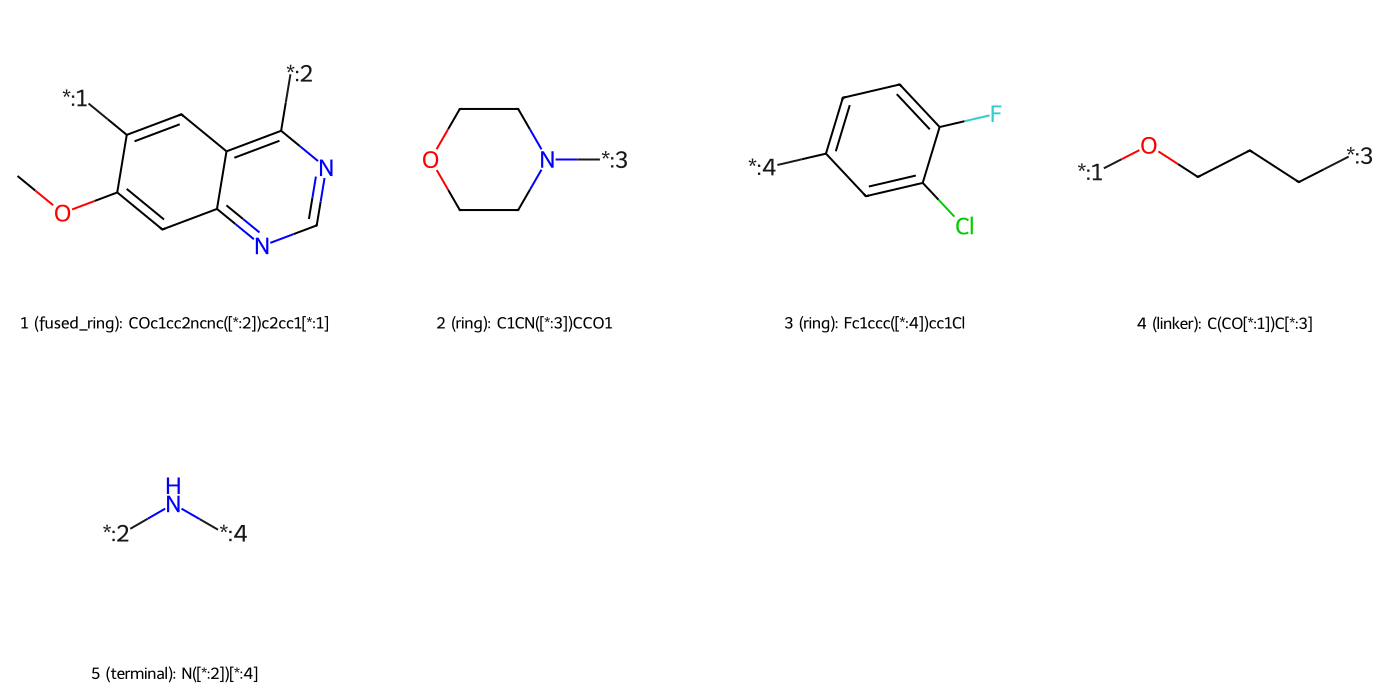

In [27]:
def visualize_decomposition(smiles: str, 
                             include_terminal_substituents: bool = True, 
                             preserve_fused_rings: bool = True,
                             show_visualization: bool = True) -> Dict[str, List[Dict]]:
    """
    Decompose a molecule from SMILES and display its fragments.
    
    Args:
        smiles: SMILES string of the molecule to decompose
        include_terminal_substituents: If True, include terminal groups as part of rings
        preserve_fused_rings: If True, keep fused/bicyclic rings together
        show_visualization: If True, display fragment images
    
    Returns:
        Dictionary with 'rings' and 'non_rings' fragment lists
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES: {smiles}")
        return {'rings': [], 'non_rings': []}
    
    # Decompose the molecule
    decomposition = decompose_molecule_with_wildcards(
        mol, 
        include_terminal_substituents=include_terminal_substituents, 
        preserve_fused_rings=preserve_fused_rings
    )

    print("=" * 60)
    print("RING FRAGMENTS")
    print("=" * 60)
    for i, frag in enumerate(decomposition['rings'], start=1):
        print(f"\nRing {i} ({frag['frag_type']}):")
        print(f"  Base SMILES:     {frag['base_smiles']}")
        print(f"  Wildcard SMILES: {frag['wildcard_smiles']}")
        test = Chem.MolFromSmiles(frag['wildcard_smiles'])
        print(f"  RDKit readable:  {test is not None}")
        print(f"  Size: {frag['size']}, Heteroatoms: {frag['hetero_count']}")
        print(f"  Attachment atoms: {frag['attachment_atoms']}")

    print("\n" + "=" * 60)
    print("NON-RING FRAGMENTS")
    print("=" * 60)
    for i, frag in enumerate(decomposition['non_rings'], start=1):
        print(f"\nFragment {i} ({frag['frag_type']}):")
        print(f"  Base SMILES:     {frag['base_smiles']}")
        print(f"  Wildcard SMILES: {frag['wildcard_smiles']}")
        test = Chem.MolFromSmiles(frag['wildcard_smiles'])
        print(f"  RDKit readable:  {test is not None}")
        print(f"  Size: {frag['size']}, Heteroatoms: {frag['hetero_count']}")
        print(f"  Attachment atoms: {frag['attachment_atoms']}")

    # Visualize all fragments
    if show_visualization:
        print("\n" + "=" * 60)
        print("VISUALIZATION")
        print("=" * 60)

        all_frags = decomposition['rings'] + decomposition['non_rings']
        if all_frags:
            mols = [f['frag_mol'] for f in all_frags]
            legends = []
            for i, f in enumerate(all_frags):
                ftype = f['frag_type']
                legends.append(f"{i+1} ({ftype}): {f['wildcard_smiles']}")
            
            grid = Draw.MolsToGridImage(mols, legends=legends, molsPerRow=4, subImgSize=(350, 350))
            display(Draw.MolToImage(mol))
            display(grid)
    
    return decomposition


# Test with gefitinib
gefitinib = "COc1cc2ncnc(c2cc1OCCCN1CCOCC1)Nc1ccc(c(c1)Cl)F"
decomposition = visualize_decomposition(gefitinib)

RING FRAGMENTS

Ring 1 (fused_ring):
  Base SMILES:     FCC12C3C4C5C3C1C5C42
  Wildcard SMILES: FCC12C3C4C1C1C2C3C41[*:1]
  RDKit readable:  True
  Size: 8, Heteroatoms: 1
  Attachment atoms: [24]

Ring 2 (ring):
  Base SMILES:     C1CNCCN1
  Wildcard SMILES: C1CN([*:3])CCN1[*:2]
  RDKit readable:  True
  Size: 6, Heteroatoms: 2
  Attachment atoms: [5, 8]

Ring 3 (ring):
  Base SMILES:     Oc1ccccc1
  Wildcard SMILES: Oc1ccccc1[*:2]
  RDKit readable:  True
  Size: 6, Heteroatoms: 1
  Attachment atoms: [9]

Ring 4 (ring):
  Base SMILES:     c1ccncc1
  Wildcard SMILES: c1ccc([*:4])nc1
  RDKit readable:  True
  Size: 6, Heteroatoms: 1
  Attachment atoms: [18]

NON-RING FRAGMENTS

Fragment 1 (linker):
  Base SMILES:     CCNC=O
  Wildcard SMILES: O=C(N(CC[*:3])[*:4])[*:1]
  RDKit readable:  True
  Size: 5, Heteroatoms: 2
  Attachment atoms: [1, 2, 4]

VISUALIZATION


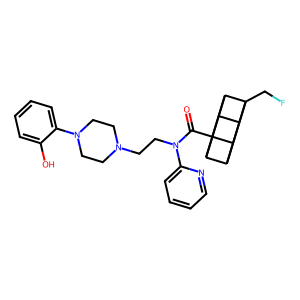

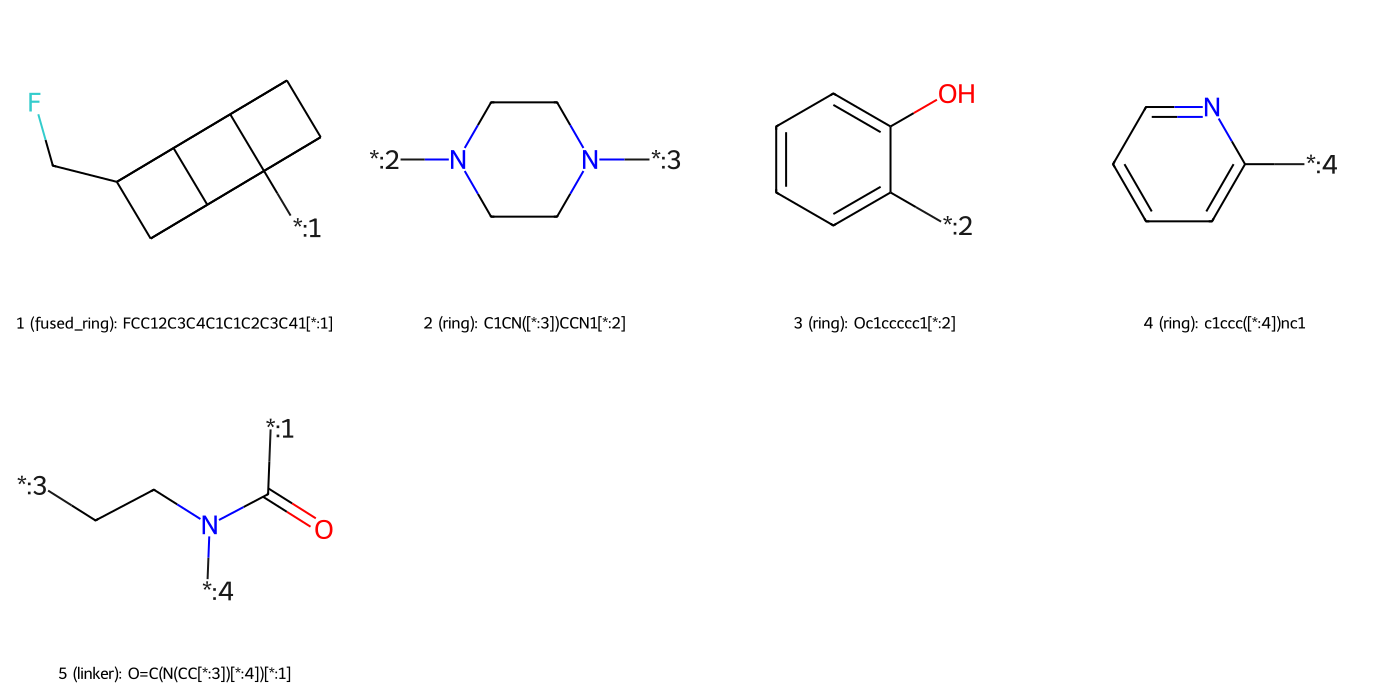

In [28]:
ch1910413 = "O=C(N(CCN1CCN(c2ccccc2O)CC1)c1ccccn1)C12C3C4C1C1C2C3C41CF"
decomposition = visualize_decomposition(ch1910413)

## Reassemble the R-groups in to the original molecule

TESTING REASSEMBLY
Output of decomposition has 2 ring(s) and 2 non-ring fragment(s).
Output of decomposition:{'rings': [{'base_smiles': 'COc1cccc2c1CCCC2', 'wildcard_smiles': 'COc1cccc2c1CCC[C@H]2[*:1]', 'frag_mol': <rdkit.Chem.rdchem.Mol object at 0x168fb6180>, 'atom_indices': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11), 'attachment_atoms': [11], 'size': 10, 'hetero_count': 1, 'frag_type': 'fused_ring', 'core_ring_atoms': (2, 3, 4, 5, 6, 7, 8, 9, 10, 11), 'total_atoms': 12}, {'base_smiles': 'c1ccc2c(c1)CCN2', 'wildcard_smiles': 'c1cc2c(cc1[*:2])N([*:3])CC2', 'frag_mol': <rdkit.Chem.rdchem.Mol object at 0x168fb61f0>, 'atom_indices': (17, 18, 19, 20, 21, 22, 23, 28, 29), 'attachment_atoms': [17, 23], 'size': 9, 'hetero_count': 1, 'frag_type': 'fused_ring', 'core_ring_atoms': (17, 18, 19, 20, 21, 22, 23, 28, 29), 'total_atoms': 9}], 'non_rings': [{'base_smiles': 'CCN(C)C', 'wildcard_smiles': 'CN(CC[*:2])C[*:1]', 'frag_mol': <rdkit.Chem.rdchem.Mol object at 0x168fb6260>, 'atom_indices': (12, 1

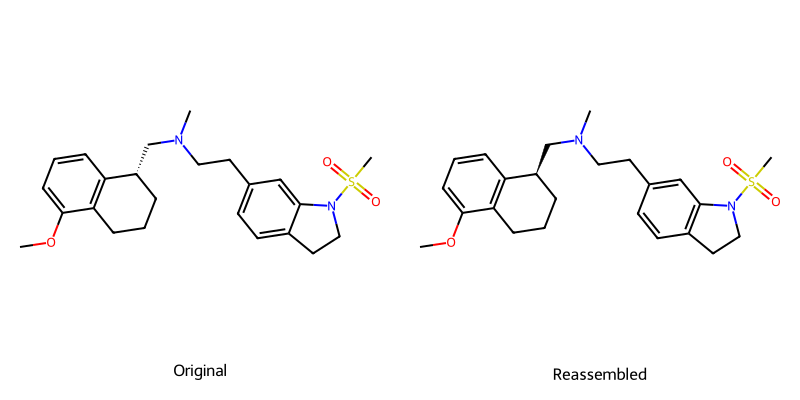

In [29]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdDepictor
from typing import List, Dict, Union

def reassemble_fragments(decomposition: Dict[str, List[Dict]], 
                         use_smiles: bool = True) -> Chem.Mol:
    """
    Reassemble fragments back into the original molecule by joining them
    at matching numbered dummy atom positions ([*:1], [*:2], etc.).
    
    Args:
        decomposition: Dictionary with 'rings' and 'non_rings' keys containing
                      fragment dictionaries (output of decompose_molecule_with_wildcards)
        use_smiles: If True, use wildcard_smiles to reconstruct; if False, use frag_mol objects
    
    Returns:
        RDKit Mol object of the reassembled molecule
    """
    all_frags = decomposition.get('rings', []) + decomposition.get('non_rings', [])
    
    if not all_frags:
        return None
    
    if len(all_frags) == 1:
        # Single fragment - just remove dummy atoms
        frag = all_frags[0]
        if use_smiles:
            mol = Chem.MolFromSmiles(frag['wildcard_smiles'])
        else:
            mol = Chem.RWMol(frag['frag_mol'])
        
        if mol is None:
            return None
        
        # Remove dummy atoms
        rw = Chem.RWMol(mol)
        atoms_to_remove = []
        for atom in rw.GetAtoms():
            if atom.GetAtomicNum() == 0:
                atoms_to_remove.append(atom.GetIdx())
        
        for idx in sorted(atoms_to_remove, reverse=True):
            rw.RemoveAtom(idx)
        
        mol = rw.GetMol()
        Chem.SanitizeMol(mol)
        return mol
    
    # Combine all fragments into one molecule
    combined = None
    for frag in all_frags:
        if use_smiles:
            frag_mol = Chem.MolFromSmiles(frag['wildcard_smiles'])
        else:
            frag_mol = frag['frag_mol']
        
        if frag_mol is None:
            continue
        
        if combined is None:
            combined = frag_mol
        else:
            combined = Chem.CombineMols(combined, frag_mol)
    
    if combined is None:
        return None
    
    # Find all dummy atoms and group them by their map number
    rw = Chem.RWMol(combined)
    
    # Build a dictionary: map_num -> list of (atom_idx, neighbor_idx, bond_type)
    dummy_map = {}
    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() == 0:  # Dummy atom
            map_num = atom.GetAtomMapNum()
            if map_num > 0:
                atom_idx = atom.GetIdx()
                # Find the neighbor (non-dummy atom connected to this dummy)
                neighbors = atom.GetNeighbors()
                if neighbors:
                    neighbor = neighbors[0]
                    neighbor_idx = neighbor.GetIdx()
                    bond = rw.GetBondBetweenAtoms(atom_idx, neighbor_idx)
                    bond_type = bond.GetBondType() if bond else Chem.BondType.SINGLE
                    
                    if map_num not in dummy_map:
                        dummy_map[map_num] = []
                    dummy_map[map_num].append((atom_idx, neighbor_idx, bond_type))
    
    # Connect fragments by creating bonds between atoms connected to matching dummies
    atoms_to_remove = set()
    
    for map_num, dummy_list in dummy_map.items():
        if len(dummy_list) >= 2:
            # Connect the first two dummies with this map number
            dummy1_idx, real1_idx, bond_type1 = dummy_list[0]
            dummy2_idx, real2_idx, bond_type2 = dummy_list[1]
            
            # Add bond between the real atoms
            # Check if bond already exists
            existing_bond = rw.GetBondBetweenAtoms(real1_idx, real2_idx)
            if existing_bond is None:
                rw.AddBond(real1_idx, real2_idx, bond_type1)
            
            # Mark dummy atoms for removal
            atoms_to_remove.add(dummy1_idx)
            atoms_to_remove.add(dummy2_idx)
    
    # Remove dummy atoms (in reverse order to maintain indices)
    for idx in sorted(atoms_to_remove, reverse=True):
        rw.RemoveAtom(idx)
    
    # Also remove any remaining unmatched dummy atoms
    remaining_dummies = []
    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() == 0:
            remaining_dummies.append(atom.GetIdx())
    
    for idx in sorted(remaining_dummies, reverse=True):
        rw.RemoveAtom(idx)
    
    mol = rw.GetMol()
    
    # Try to sanitize
    try:
        Chem.SanitizeMol(mol)
    except:
        # Try clearing aromaticity first
        try:
            for atom in mol.GetAtoms():
                atom.SetIsAromatic(False)
            for bond in mol.GetBonds():
                bond.SetIsAromatic(False)
            Chem.SanitizeMol(mol)
        except:
            pass
    
    # Generate 2D coordinates for visualization
    try:
        rdDepictor.Compute2DCoords(mol)
    except:
        pass
    
    return mol


def reassemble_from_smiles_list(smiles_list: List[str]) -> Chem.Mol:
    """
    Reassemble a molecule from a list of fragment SMILES with numbered dummy atoms.
    
    This is a convenience function when you have SMILES strings directly
    rather than the full decomposition dictionary.
    
    Args:
        smiles_list: List of SMILES strings with [*:n] notation for connection points
    
    Returns:
        RDKit Mol object of the reassembled molecule
    """
    # Create a fake decomposition dict
    decomposition = {
        'rings': [],
        'non_rings': []
    }
    
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            decomposition['non_rings'].append({
                'wildcard_smiles': smi,
                'frag_mol': mol
            })
    
    return reassemble_fragments(decomposition, use_smiles=True)


# Test the reassembly function
print("=" * 60)
print("TESTING REASSEMBLY")
print("=" * 60)

# First decompose the molecule
decomposition = decompose_molecule_with_wildcards(mol, include_terminal_substituents=True, preserve_fused_rings=True)
print(f"Output of decomposition has {len(decomposition['rings'])} ring(s) and {len(decomposition['non_rings'])} non-ring fragment(s).")
print(f"Output of decomposition:{decomposition}")
print(f"Type {type(decomposition)}")
print(decomposition['rings'])

print("\nOriginal molecule SMILES:")
original_smiles = Chem.MolToSmiles(mol, canonical=True)
print(f"  {original_smiles}")

print("\nFragments being reassembled:")
all_frags = decomposition['rings'] + decomposition['non_rings']
for i, f in enumerate(all_frags, 1):
    print(f"  {i}. {f['wildcard_smiles']} ({f['frag_type']})")

# Reassemble
reassembled = reassemble_fragments(decomposition)

if reassembled:
    reassembled_smiles = Chem.MolToSmiles(reassembled, canonical=True)
    print(f"\nReassembled molecule SMILES:")
    print(f"  {reassembled_smiles}")
    
    # Check if they match
    match = (original_smiles == reassembled_smiles)
    print(f"\nSMILES match: {match}")
    
    if not match:
        # Check by InChI which is more canonical
        from rdkit.Chem.inchi import MolToInchi
        orig_inchi = MolToInchi(mol)
        reasm_inchi = MolToInchi(reassembled)
        inchi_match = (orig_inchi == reasm_inchi)
        print(f"InChI match: {inchi_match}")
    
    # Visualize comparison
    print("\nVisualization (Original vs Reassembled):")
    grid = Draw.MolsToGridImage([mol, reassembled], 
                                 legends=["Original", "Reassembled"],
                                 molsPerRow=2, subImgSize=(400, 400))
    display(grid)
else:
    print("\nReassembly failed!")

## Simple function to fragment and reassemble from SMILES list of wildcard fragments

Here we create two cleaner functions in the new cell: one that returns just a list of wildcard SMILES, and another that reassembles from that list.

SIMPLIFIED WORKFLOW: SMILES LIST → REASSEMBLE

STEP 1: Decompose molecule into fragment SMILES
----------------------------------------------------------------------
Got 8 fragments:

  1. Cc1ccc([*:1])cc1[*:2]
  2. c1cc([*:4])ccc1[*:3]
  3. CN1CCN([*:5])CC1
  4. c1cc([*:6])nc([*:7])n1
  5. c1cncc([*:6])c1
  6. O=C(N[*:1])[*:3]
  7. C([*:4])[*:5]
  8. N([*:2])[*:7]

STEP 2: Reassemble from fragment SMILES
----------------------------------------------------------------------
Original SMILES:    Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1
Reassembled SMILES: Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1

✓ SMILES match: True

STEP 3: Visualization
----------------------------------------------------------------------

Fragments:


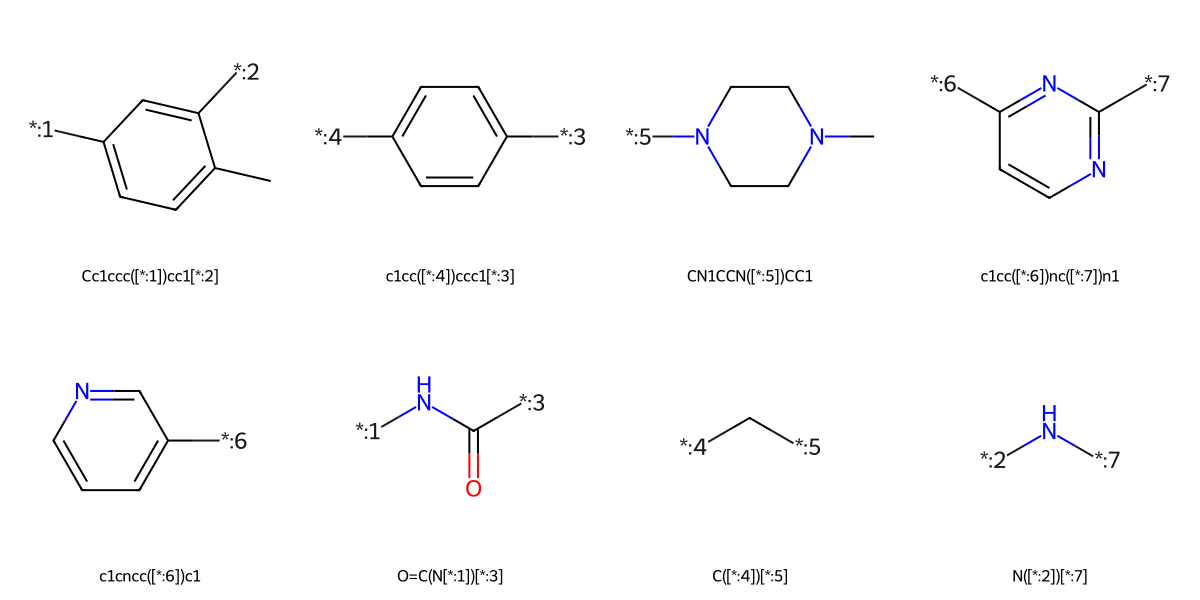


Original vs Reassembled:


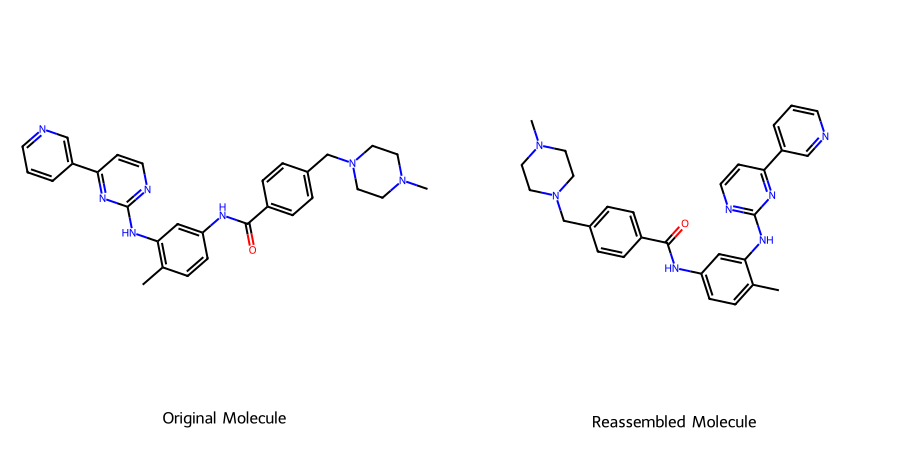


USAGE EXAMPLE:

# Decompose a molecule (includes terminal substituents up to 3 heavy atoms)
fragments = decompose_to_smiles(mol, max_terminal_atoms=3)
# Result: ['[*:1]c1ccccc1[*:2]', '[*:1]C(=O)O', '[*:2]N', ...]

# Optionally modify fragments here
# fragments[0] = '[*:1]c1ncccc1[*:2]'  # Replace benzene with pyridine

# Reassemble into new molecule
new_mol = reassemble_from_smiles(fragments)



In [30]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from typing import List
from IPython.display import display


def decompose_to_smiles(mol: Chem.Mol, 
                        include_terminal_substituents: bool = True,
                        preserve_fused_rings: bool = True,
                        max_terminal_atoms: int = 3) -> List[str]:
    """
    Decompose a molecule into a list of fragment SMILES with numbered dummy atoms.
    
    This is a simplified version that just returns SMILES strings, making it easy
    to store, modify, and reassemble fragments.
    
    Args:
        mol: RDKit Mol object
        include_terminal_substituents: If True, include terminal groups as part of rings
        preserve_fused_rings: If True, keep fused/bicyclic rings together
        max_terminal_atoms: Maximum number of heavy atoms in terminal substituents to include (default: 3)
    
    Returns:
        List of SMILES strings with numbered wildcard atoms ([*:1], [*:2], etc.)
        Connected fragments have matching numbers.
    
    Example:
        >>> mol = Chem.MolFromSmiles("CC1=CC=CC=C1")
        >>> frags = decompose_to_smiles(mol)
        >>> print(frags)
        ['Cc1ccccc1']  # Simple molecule with one ring
    """
    # Use the existing function to get full decomposition
    decomposition = decompose_molecule_with_wildcards(
        mol, 
        include_terminal_substituents=include_terminal_substituents,
        preserve_fused_rings=preserve_fused_rings,
        max_terminal_atoms=max_terminal_atoms
    )
    
    # Extract just the SMILES strings
    smiles_list = []
    
    for frag in decomposition.get('rings', []):
        smiles_list.append(frag['wildcard_smiles'])
    
    for frag in decomposition.get('non_rings', []):
        smiles_list.append(frag['wildcard_smiles'])
    
    return smiles_list


def reassemble_from_smiles(smiles_list: List[str]) -> Chem.Mol:
    """
    Reassemble a molecule from fragment SMILES with numbered dummy atoms.
    
    Fragments are connected by matching their dummy atom numbers.
    For example, [*:1] in one fragment connects to [*:1] in another fragment.
    
    Args:
        smiles_list: List of SMILES strings with [*:n] wildcard notation
    
    Returns:
        RDKit Mol object of the reassembled molecule, or None if failed
    
    Example:
        >>> frags = ['[*:1]c1ccccc1', '[*:1]C']
        >>> mol = reassemble_from_smiles(frags)
        >>> Chem.MolToSmiles(mol)
        'Cc1ccccc1'  # Toluene
    """
    if not smiles_list:
        return None
    
    # Parse all SMILES into molecules
    mols = []
    for smi in smiles_list:
        m = Chem.MolFromSmiles(smi)
        if m is not None:
            mols.append(m)
    
    if not mols:
        return None
    
    # Single fragment - just remove dummy atoms
    if len(mols) == 1:
        rw = Chem.RWMol(mols[0])
        atoms_to_remove = [a.GetIdx() for a in rw.GetAtoms() if a.GetAtomicNum() == 0]
        for idx in sorted(atoms_to_remove, reverse=True):
            rw.RemoveAtom(idx)
        mol = rw.GetMol()
        try:
            Chem.SanitizeMol(mol)
        except:
            pass
        return mol
    
    # Combine all molecules into one disconnected molecule
    combined = mols[0]
    for m in mols[1:]:
        combined = Chem.CombineMols(combined, m)
    
    rw = Chem.RWMol(combined)
    
    # Find all dummy atoms and group by their map number
    dummy_map = {}  # map_num -> [(dummy_idx, neighbor_idx, bond_type)]
    for atom in rw.GetAtoms():
        if atom.GetAtomicNum() == 0:  # Dummy atom (*)
            map_num = atom.GetAtomMapNum()
            if map_num > 0:
                neighbors = atom.GetNeighbors()
                if neighbors:
                    neighbor_idx = neighbors[0].GetIdx()
                    bond = rw.GetBondBetweenAtoms(atom.GetIdx(), neighbor_idx)
                    bond_type = bond.GetBondType() if bond else Chem.BondType.SINGLE
                    
                    if map_num not in dummy_map:
                        dummy_map[map_num] = []
                    dummy_map[map_num].append((atom.GetIdx(), neighbor_idx, bond_type))
    
    # Connect fragments by joining atoms with matching dummy numbers
    atoms_to_remove = set()
    
    for map_num, dummy_list in dummy_map.items():
        if len(dummy_list) >= 2:
            # Connect the two fragments with this map number
            dummy1_idx, real1_idx, bond_type = dummy_list[0]
            dummy2_idx, real2_idx, _ = dummy_list[1]
            
            # Create bond between the real atoms
            if rw.GetBondBetweenAtoms(real1_idx, real2_idx) is None:
                rw.AddBond(real1_idx, real2_idx, bond_type)
            
            # Mark dummies for removal
            atoms_to_remove.add(dummy1_idx)
            atoms_to_remove.add(dummy2_idx)
    
    # Remove matched dummy atoms
    for idx in sorted(atoms_to_remove, reverse=True):
        rw.RemoveAtom(idx)
    
    # Remove any remaining unmatched dummies
    remaining = [a.GetIdx() for a in rw.GetAtoms() if a.GetAtomicNum() == 0]
    for idx in sorted(remaining, reverse=True):
        rw.RemoveAtom(idx)
    
    mol = rw.GetMol()
    
    # Sanitize the molecule
    try:
        Chem.SanitizeMol(mol)
    except:
        try:
            for atom in mol.GetAtoms():
                atom.SetIsAromatic(False)
            for bond in mol.GetBonds():
                bond.SetIsAromatic(False)
            Chem.SanitizeMol(mol)
        except:
            pass
    
    # Generate 2D coordinates
    try:
        rdDepictor.Compute2DCoords(mol)
    except:
        pass
    
    return mol


# ============================================================================
# DEMONSTRATION OF THE WORKFLOW
# ============================================================================

print("=" * 70)
print("SIMPLIFIED WORKFLOW: SMILES LIST → REASSEMBLE")
print("=" * 70)

# Test with imatinib-like molecule
test_smiles = "CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5"
test_mol = Chem.MolFromSmiles(test_smiles)

print("\nSTEP 1: Decompose molecule into fragment SMILES")
print("-" * 70)
fragments = decompose_to_smiles(test_mol, max_terminal_atoms=3)
print(f"Got {len(fragments)} fragments:\n")
for i, smi in enumerate(fragments, 1):
    print(f"  {i}. {smi}")

print("\nSTEP 2: Reassemble from fragment SMILES")
print("-" * 70)
reassembled = reassemble_from_smiles(fragments)

if reassembled:
    orig_smi = Chem.MolToSmiles(test_mol, canonical=True)
    reasm_smi = Chem.MolToSmiles(reassembled, canonical=True)
    
    print(f"Original SMILES:    {orig_smi}")
    print(f"Reassembled SMILES: {reasm_smi}")
    print(f"\n✓ SMILES match: {orig_smi == reasm_smi}")
    
    if orig_smi != reasm_smi:
        from rdkit.Chem.inchi import MolToInchi
        match = MolToInchi(test_mol) == MolToInchi(reassembled)
        print(f"✓ InChI match: {match}")

print("\nSTEP 3: Visualization")
print("-" * 70)

# Show the fragments
frag_mols = [Chem.MolFromSmiles(s) for s in fragments if Chem.MolFromSmiles(s)]
if frag_mols:
    print("\nFragments:")
    grid1 = Draw.MolsToGridImage(
        frag_mols, 
        legends=fragments,
        molsPerRow=4, 
        subImgSize=(300, 300)
    )
    display(grid1)

# Compare original vs reassembled
print("\nOriginal vs Reassembled:")
grid2 = Draw.MolsToGridImage(
    [test_mol, reassembled],
    legends=["Original Molecule", "Reassembled Molecule"],
    molsPerRow=2,
    subImgSize=(450, 450)
)
display(grid2)

print("\n" + "=" * 70)
print("USAGE EXAMPLE:")
print("=" * 70)
print("""
# Decompose a molecule (includes terminal substituents up to 3 heavy atoms)
fragments = decompose_to_smiles(mol, max_terminal_atoms=3)
# Result: ['[*:1]c1ccccc1[*:2]', '[*:1]C(=O)O', '[*:2]N', ...]

# Optionally modify fragments here
# fragments[0] = '[*:1]c1ncccc1[*:2]'  # Replace benzene with pyridine

# Reassemble into new molecule
new_mol = reassemble_from_smiles(fragments)
""")

In [31]:
#test with gefitinib
gef_list = decompose_to_smiles(Chem.MolFromSmiles("COc1cc2ncnc(c2cc1OCCCN1CCOCC1)Nc1ccc(c(c1)Cl)F"))
print("\nGefitinib fragments:")
for i, smi in enumerate(gef_list, 1):
    print(f"  {i}. {smi}")

#reassemble gefitinib
reassembled_gef = reassemble_from_smiles(gef_list)
if reassembled_gef:
    print(f"\nReassembled Gefitinib SMILES: {reassembled_gef}")


Gefitinib fragments:
  1. COc1cc2ncnc([*:2])c2cc1[*:1]
  2. C1CN([*:3])CCO1
  3. Fc1ccc([*:4])cc1Cl
  4. C(CO[*:1])C[*:3]
  5. N([*:2])[*:4]

Reassembled Gefitinib SMILES: <rdkit.Chem.rdchem.Mol object at 0x16901ef10>



Reassembled Random SMILES: <rdkit.Chem.rdchem.Mol object at 0x16901ec00>


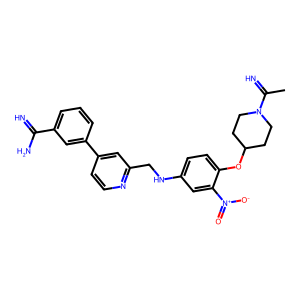

In [32]:
random_list = ['N=C(N)c1cccc([*:1])c1', 'c1cc([*:1])cc([*:2])n1', 'O=[N+]([O-])c1cc([*:4])ccc1[*:3]', 'CC(=N)N1CCC([*:5])CC1', 'O([*:3])[*:5]', 'C(N[*:4])[*:2]']
#reassemble gefitinib
reassembled_ran = reassemble_from_smiles(random_list)
if reassembled_ran:
    print(f"\nReassembled Random SMILES: {reassembled_ran}")

Draw.MolToImage(reassembled_ran)

In [33]:
['Cc1ccc(NC(=O)[*:3])cc1[*:2]', 'Cc1ccc([*:1])cc1N[*:7]', 'O=C(N[*:1])c1ccc([*:4])cc1', 'c1cc([*:3])ccc1C[*:5]', 'CN1CCN(C[*:4])CC1', 'c1cncc(-c2ccnc([*:7])n2)c1', 'c1cc([*:6])nc(N[*:2])n1']

['Cc1ccc(NC(=O)[*:3])cc1[*:2]',
 'Cc1ccc([*:1])cc1N[*:7]',
 'O=C(N[*:1])c1ccc([*:4])cc1',
 'c1cc([*:3])ccc1C[*:5]',
 'CN1CCN(C[*:4])CC1',
 'c1cncc(-c2ccnc([*:7])n2)c1',
 'c1cc([*:6])nc(N[*:2])n1']

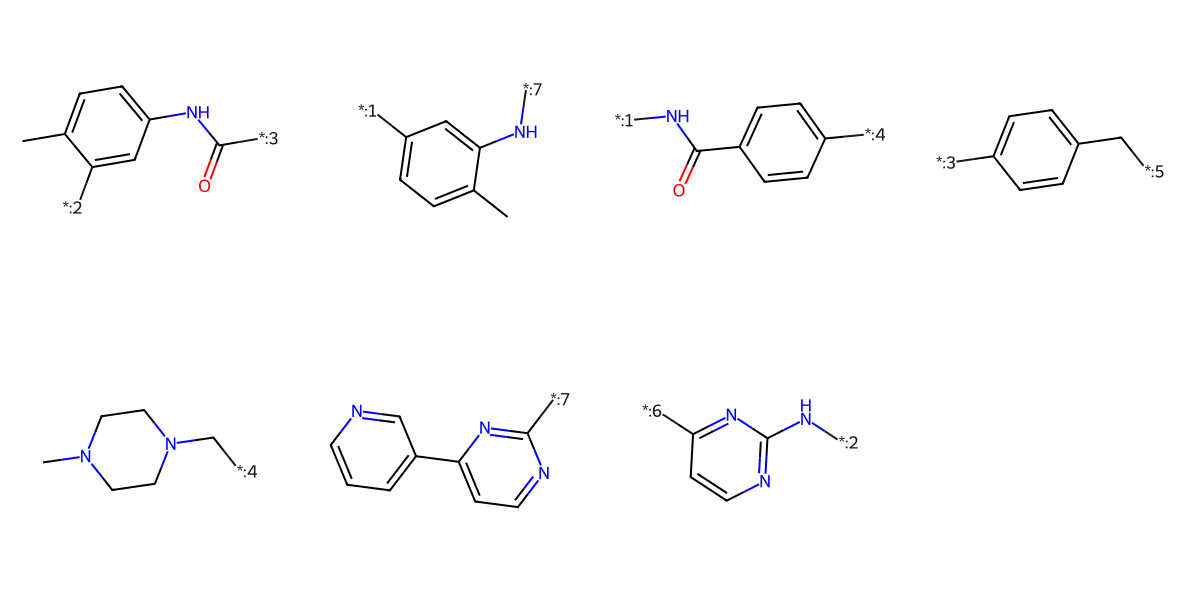

In [34]:
#Test with pariwise combination of fragments

ima_pa = ['Cc1ccc(NC(=O)[*:3])cc1[*:2]', 'Cc1ccc([*:1])cc1N[*:7]', 'O=C(N[*:1])c1ccc([*:4])cc1', 'c1cc([*:3])ccc1C[*:5]', 'CN1CCN(C[*:4])CC1', 'c1cncc(-c2ccnc([*:7])n2)c1', 'c1cc([*:6])nc(N[*:2])n1']
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in ima_pa], molsPerRow=4, subImgSize=(300,300))

# Visualise and clean the chembl dataset

In [35]:
#kin = pd.read_csv("../data/Kinase_inhibitors_chembl.csv", sep=";", on_bad_lines='skip')
kin = pd.read_csv("../data/whole_filtered_chembl_with_smiles.csv.gz", on_bad_lines='skip')

kin.shape

(537080, 13)

In [36]:
kin.head(3)

,chembl_id,pchembl_value,assay_confidence_score,assay_chembl_id,target_chembl_id,standard_type,standard_value,standard_units,mw,logp,rotatable_bonds,ID,SMILES
0,CHEMBL268439,8.22,NaN,CHEMBL873200,CHEMBL261,Ki,6.00,nM,335.392,-0.43150,4,NaN,Nc1ccc(S(=O)(=O)Nc2nnc(S(N)(=O)=O)s2)cc1
1,CHEMBL302907,7.60,NaN,CHEMBL694844,CHEMBL2882,Kd,25.12,nM,346.467,0.89357,7,NaN,N=C(N)Nc1nc(CSCCNc2n[s+]([O-])nc2N)cs1
2,CHEMBL305153,7.43,NaN,CHEMBL655651,CHEMBL5471,Kd,37.15,nM,324.424,3.18500,5,NaN,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21


Let's check if all smiles are valid:

In [ ]:
df_smiles = kin['SMILES']

ok_smiles = []
delete_smiles = []
i=0

for ds in df_smiles:
		try:
				cs = Chem.CanonSmiles(ds)
				ok_smiles.append(cs)
				i=i+1
		except:
				print('Invalid SMILES:', ds)
				delete_smiles.append(ds)
print("")
print(f"Total valid SMILES: {i}")
print(f"Total invalid SMILES: {len(delete_smiles)}")

#Remove invalid smiles from dataframe
kin_cleaned = kin[~kin['SMILES'].isin(delete_smiles)]
kin_cleaned.shape

Invalid SMILES: COc1ccc(Nc2nnc(Cc3ccc(Cl)cc3)c(O)n2)c(OC)c1


## Clean the test chembl library

In [ ]:
#keep the largest fragment for each molecule
def get_largest_fragment(smiles: str) -> str:
    """Return the largest fragment from a SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    if not frags:
        return None
    
    # Find the fragment with the maximum number of heavy atoms
    largest_frag = max(frags, key=lambda m: m.GetNumHeavyAtoms())
    
    return Chem.MolToSmiles(largest_frag, canonical=True)

kin_largest_frags = kin_cleaned.copy()
kin_largest_frags['Largest_Fragment'] = kin_largest_frags['SMILES'].apply(get_largest_fragment)
kin_largest_frags.shape

(537080, 14)

In [17]:
#Get mol object
kin_largest_frags['Mol'] = kin_largest_frags['Largest_Fragment'].apply(Chem.MolFromSmiles)
kin_largest_frags.head(3)

,chembl_id,pchembl_value,assay_confidence_score,assay_chembl_id,target_chembl_id,standard_type,standard_value,standard_units,mw,logp,rotatable_bonds,ID,SMILES,Largest_Fragment,Mol
0,CHEMBL268439,8.22,NaN,CHEMBL873200,CHEMBL261,Ki,6.00,nM,335.392,-0.43150,4,NaN,Nc1ccc(S(=O)(=O)Nc2nnc(S(N)(=O)=O)s2)cc1,Nc1ccc(S(=O)(=O)Nc2nnc(S(N)(=O)=O)s2)cc1,<rdkit.Chem.rdchem.Mol object at 0x333a897e0>
1,CHEMBL302907,7.60,NaN,CHEMBL694844,CHEMBL2882,Kd,25.12,nM,346.467,0.89357,7,NaN,N=C(N)Nc1nc(CSCCNc2n[s+]([O-])nc2N)cs1,N=C(N)Nc1nc(CSCCNc2n[s+]([O-])nc2N)cs1,<rdkit.Chem.rdchem.Mol object at 0x33b75e810>
2,CHEMBL305153,7.43,NaN,CHEMBL655651,CHEMBL5471,Kd,37.15,nM,324.424,3.18500,5,NaN,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,CC(C)(C)NC[C@H](O)CON=C1c2ccccc2-c2ccccc21,<rdkit.Chem.rdchem.Mol object at 0x33b75e7a0>


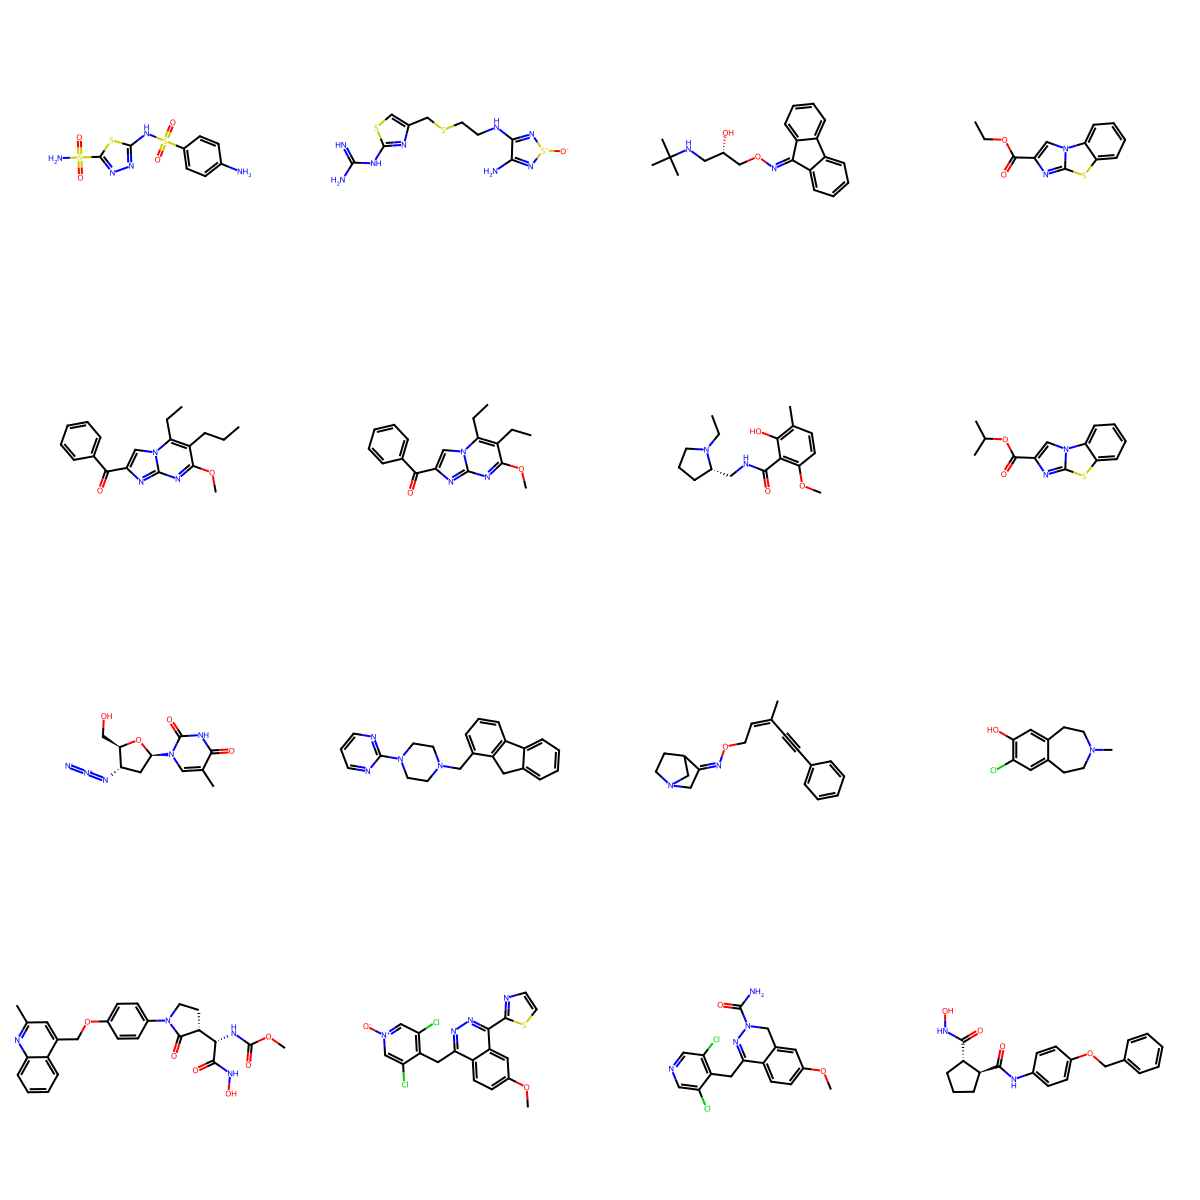

In [18]:
#Visualise the molecules
Draw.MolsToGridImage(kin_largest_frags['Mol'].tolist()[:16], molsPerRow=4, subImgSize=(300,300))

Let's save the cleaned dataset

In [19]:
#kin_largest_frags.to_csv("../data/cleaned_whole_filtered_chembl_with_smiles.csv.gz", index=False)

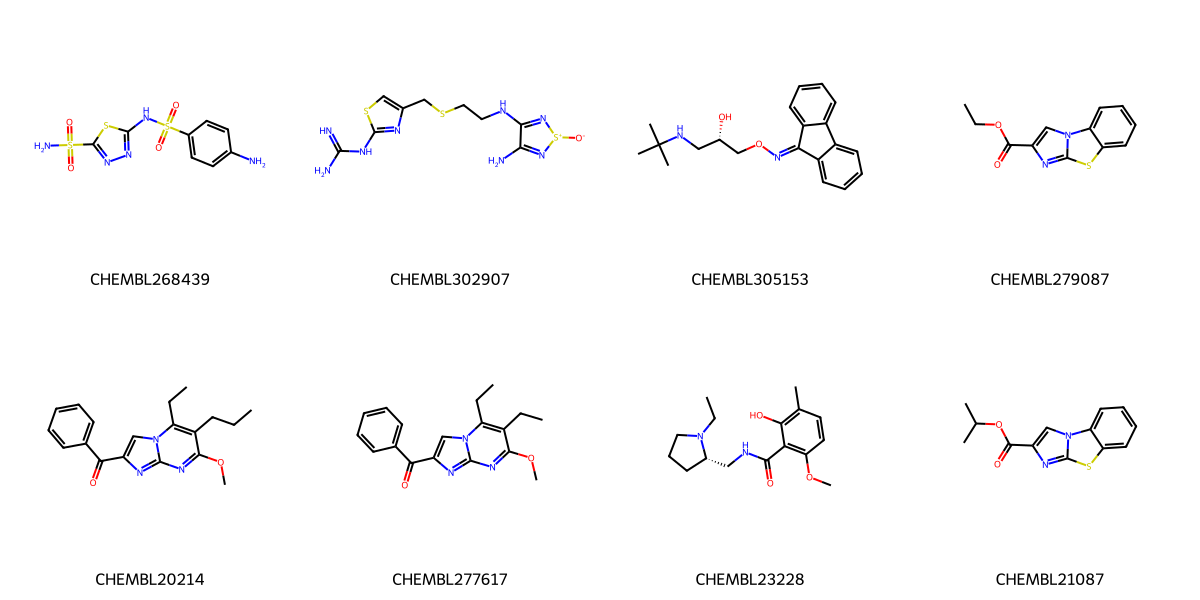

In [20]:
#Visualise the molecules
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in kin_largest_frags['Largest_Fragment'][:8]], molsPerRow=4, subImgSize=(300,300), legends=kin_largest_frags['chembl_id'][:8].tolist())

# Fragment the test Chembl library

In [21]:
#Using the function decompose_to_smiles to decompose molecules
import gzip

fragmented_smiles = []
for smi in kin_largest_frags['Largest_Fragment']:
    mol = Chem.MolFromSmiles(smi)
    frags = decompose_to_smiles(mol, include_terminal_substituents=True, preserve_fused_rings=True)
    fragmented_smiles.append(frags)
    
#Save the fragments in a compressed txt.gz file in data folder, one below the other
# UNCOMMENT the lines below to save the fragments

# with gzip.open("../data/fragments_cleaned_whole_filtered_chembl_with_smiles.txt.gz", "wt", encoding='utf-8') as f:
#     for frags in fragmented_smiles:
#         f.write("\n".join(frags) + "\n")
#     print("Fragments saved to data/fragments_cleaned_whole_filtered_chembl_with_smiles.txt.gz")

KeyboardInterrupt: 


Fragments of the first molecule:


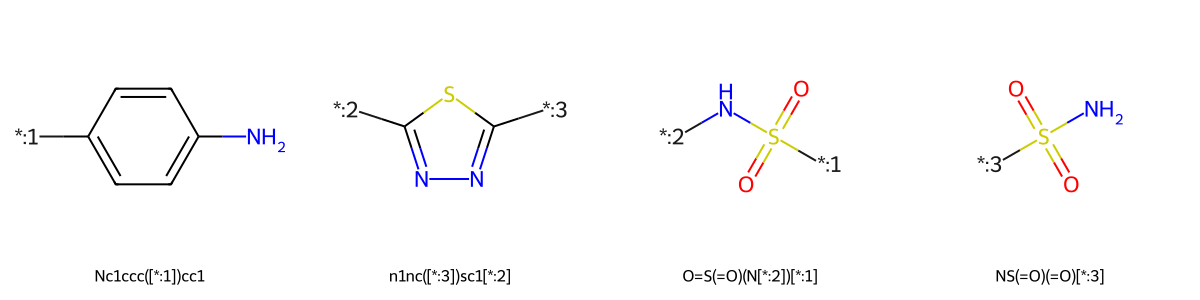

In [ ]:
#display the 2D structure of fragments of the first molecule
first_mol_frags = fragmented_smiles[0]
frag_mols = [Chem.MolFromSmiles(s) for s in first_mol_frags if Chem.MolFromSmiles(s)]
if frag_mols:
    print("\nFragments of the first molecule:")
    grid = Draw.MolsToGridImage(
        frag_mols, 
        legends=first_mol_frags,
        molsPerRow=4, 
        subImgSize=(300, 300)
    )
    display(grid)


First molecule:


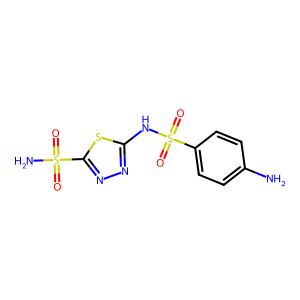

In [ ]:
#See what the first molecule is
first_mol = Chem.MolFromSmiles(kin_largest_frags['Largest_Fragment'].iloc[0])
print(first_mol)
print("\nFirst molecule:")
Draw.MolToImage(first_mol, size=(300,300))

## Fragment Similarity Search

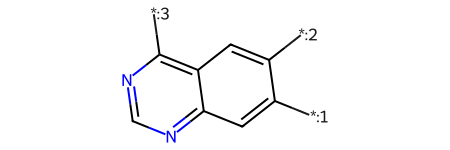

In [ ]:
gef_sc = "c1nc([*:3])c2cc([*:2])c([*:1])cc2n1"
Chem.MolFromSmiles(gef_sc)

I wish to find any fragments that are similar to the gefinitib fragment above, with same number of attachment points

Query fragment: c1nc([*:3])c2cc([*:2])c([*:1])cc2n1
Query structure:


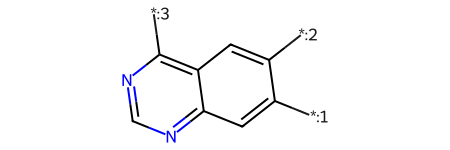


Searching for similar fragments...

Found 20 similar fragments with 3 attachment points:
1. Similarity: 0.464 | Attachments: 3 | c1cc([*:3])c2cc([*:2])c([*:1])cc2n1
2. Similarity: 0.367 | Attachments: 3 | c1cc([*:3])c2cc([*:2])c([*:1])nc2c1
3. Similarity: 0.355 | Attachments: 3 | c1cc2ncc([*:1])c([*:2])c2cc1[*:3]
4. Similarity: 0.333 | Attachments: 3 | O=C1C([*:1])=C([*:2])C(=O)c2c1ncnc2[*:3]
5. Similarity: 0.333 | Attachments: 3 | c1cc2nc([*:1])c([*:2])nc2c([*:3])n1
6. Similarity: 0.323 | Attachments: 3 | c1c([*:1])c([*:2])cc2c1ncn2[*:3]
7. Similarity: 0.303 | Attachments: 3 | c1cc2nnc([*:1])c([*:2])c2cc1[*:3]
8. Similarity: 0.300 | Attachments: 3 | c1c([*:1])c([*:2])cc2c([*:3])n[nH]c12
9. Similarity: 0.294 | Attachments: 3 | c1cc2cnc([*:3])nc2c([*:2])c1[*:1]
10. Similarity: 0.289 | Attachments: 3 | O=c1c2c([*:3])nccc2nc([*:1])n1[*:2]
11. Similarity: 0.281 | Attachments: 3 | c1cc([*:3])c2ncc([*:1])c([*:2])c2c1
12. Similarity: 0.281 | Attachments: 3 | c1nn([*:3])c2cc([*:2])c([*:1])cc1

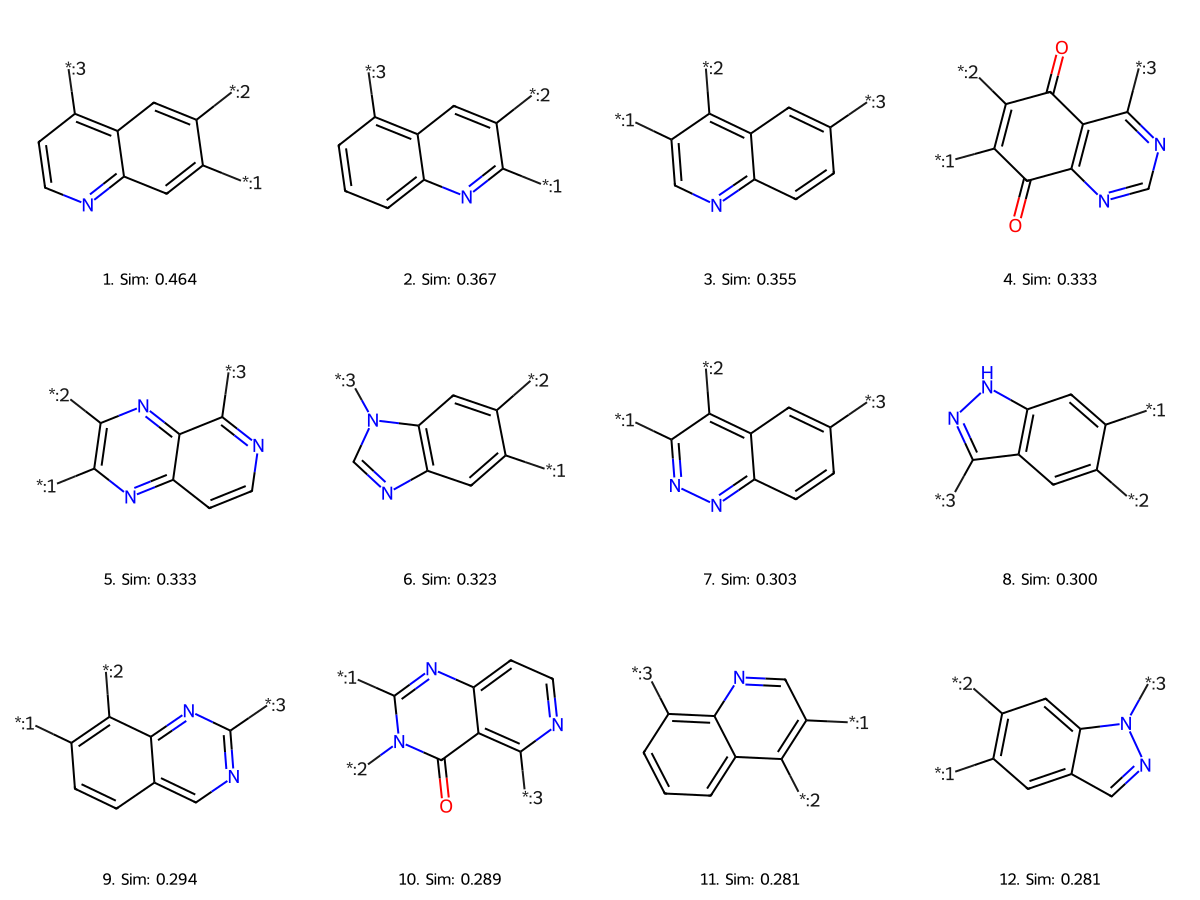

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator
from rdkit import DataStructs
from rdkit import RDLogger
from typing import List, Tuple, Dict
from itertools import permutations
import gzip

def find_similar_fragments(query_smiles: str, 
                           fragments_file: str,
                           similarity_threshold: float = 0.3,
                           top_n: int = 20) -> List[Tuple[str, float, int]]:
    """
    Find fragments similar to a query SMILES with the same number of attachment points.
    
    For queries with multiple attachment points, also filters for fragments with the same
    pairwise distances between attachment points. The returned fragments have their dummy 
    atoms renumbered to match the numbering scheme of the query molecule.
    
    Args:
        query_smiles: SMILES string of the query fragment (with [*:n] wildcards)
        fragments_file: Path to file containing fragment SMILES (one per line).
                       Supports both .txt and .txt.gz (gzip compressed) files.
        similarity_threshold: Minimum Tanimoto similarity (0-1)
        top_n: Maximum number of results to return
    
    Returns:
        List of tuples: (smiles, similarity_score, num_attachments)
        Sorted by similarity score (highest first)
        SMILES will have renumbered dummy atoms matching query's numbering scheme
    """
    # Suppress RDKit warnings (including kekulization warnings)
    RDLogger.DisableLog('rdApp.*')
    
    def get_attachment_info(mol: Chem.Mol) -> List[Tuple[int, int, int]]:
        """
        Get information about attachment points.
        Returns list of (dummy_atom_idx, neighbor_atom_idx, map_num) for each dummy atom.
        """
        info = []
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() == 0:  # Dummy atom
                dummy_idx = atom.GetIdx()
                map_num = atom.GetAtomMapNum()
                neighbors = atom.GetNeighbors()
                if neighbors:
                    neighbor_idx = neighbors[0].GetIdx()
                    info.append((dummy_idx, neighbor_idx, map_num))
        return info
    
    def get_distance_matrix(mol: Chem.Mol, attachment_info: List[Tuple[int, int, int]]) -> Dict[Tuple[int, int], int]:
        """
        Calculate pairwise distances between attachment points (neighbors of dummies).
        Returns dict mapping (map_num1, map_num2) -> distance
        """
        distances = {}
        n = len(attachment_info)
        for i in range(n):
            for j in range(i + 1, n):
                _, neighbor_i, map_i = attachment_info[i]
                _, neighbor_j, map_j = attachment_info[j]
                try:
                    path = Chem.GetShortestPath(mol, neighbor_i, neighbor_j)
                    if path:
                        dist = len(path) - 1
                        distances[(map_i, map_j)] = dist
                        distances[(map_j, map_i)] = dist
                except:
                    pass
        return distances
    
    def get_sorted_distances(mol: Chem.Mol) -> Tuple[int, ...]:
        """
        Calculate ALL pairwise distances between attachment points.
        Returns a sorted tuple of distances for comparison.
        """
        attachment_info = get_attachment_info(mol)
        if len(attachment_info) < 2:
            return ()
        
        distances = []
        for i in range(len(attachment_info)):
            for j in range(i + 1, len(attachment_info)):
                _, neighbor_i, _ = attachment_info[i]
                _, neighbor_j, _ = attachment_info[j]
                try:
                    path = Chem.GetShortestPath(mol, neighbor_i, neighbor_j)
                    if path:
                        distances.append(len(path) - 1)
                except:
                    pass
        return tuple(sorted(distances))
    
    def find_mapping(query_info: List[Tuple[int, int, int]], 
                     query_distances: Dict[Tuple[int, int], int],
                     frag_info: List[Tuple[int, int, int]], 
                     frag_mol: Chem.Mol) -> Dict[int, int]:
        """
        Find a mapping from fragment dummy map numbers to query dummy map numbers
        that preserves the pairwise distance relationships.
        
        Returns dict mapping frag_map_num -> query_map_num, or empty dict if no valid mapping.
        """
        query_map_nums = [info[2] for info in query_info]
        frag_map_nums = [info[2] for info in frag_info]
        
        # Build fragment distance matrix
        frag_distances = {}
        for i in range(len(frag_info)):
            for j in range(i + 1, len(frag_info)):
                _, neighbor_i, map_i = frag_info[i]
                _, neighbor_j, map_j = frag_info[j]
                try:
                    path = Chem.GetShortestPath(frag_mol, neighbor_i, neighbor_j)
                    if path:
                        dist = len(path) - 1
                        frag_distances[(map_i, map_j)] = dist
                        frag_distances[(map_j, map_i)] = dist
                except:
                    pass
        
        # Try all permutations to find a valid mapping
        for perm in permutations(query_map_nums):
            # Create mapping: frag_map_nums[i] -> perm[i]
            mapping = dict(zip(frag_map_nums, perm))
            
            # Check if this mapping preserves distances
            valid = True
            for i in range(len(frag_map_nums)):
                for j in range(i + 1, len(frag_map_nums)):
                    frag_m1, frag_m2 = frag_map_nums[i], frag_map_nums[j]
                    query_m1, query_m2 = mapping[frag_m1], mapping[frag_m2]
                    
                    frag_dist = frag_distances.get((frag_m1, frag_m2))
                    query_dist = query_distances.get((query_m1, query_m2))
                    
                    if frag_dist != query_dist:
                        valid = False
                        break
                if not valid:
                    break
            
            if valid:
                return mapping
        
        return {}
    
    def renumber_fragment(smiles: str, mapping: Dict[int, int]) -> str:
        """
        Renumber the dummy atoms in a fragment SMILES according to the mapping.
        """
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return smiles
        
        rw = Chem.RWMol(mol)
        for atom in rw.GetAtoms():
            if atom.GetAtomicNum() == 0:
                old_map = atom.GetAtomMapNum()
                if old_map in mapping:
                    atom.SetAtomMapNum(mapping[old_map])
        
        return Chem.MolToSmiles(rw.GetMol(), canonical=True)
    
    def replace_dummies_with_h(mol: Chem.Mol) -> Chem.Mol:
        """
        Replace dummy atoms with hydrogen atoms instead of removing them.
        This preserves valences and allows proper sanitization of aromatic systems.
        """
        rw = Chem.RWMol(mol)
        for atom in rw.GetAtoms():
            if atom.GetAtomicNum() == 0:  # Dummy atom
                atom.SetAtomicNum(1)  # Replace with hydrogen
                atom.SetAtomMapNum(0)
        return rw.GetMol()
    
    # Parse query molecule
    query_mol = Chem.MolFromSmiles(query_smiles)
    if query_mol is None:
        print(f"Invalid query SMILES: {query_smiles}")
        return []
    
    # Get query attachment info
    query_attachment_info = get_attachment_info(query_mol)
    query_attachments = len(query_attachment_info)
    
    # Calculate query distances (both sorted tuple for filtering and full matrix for mapping)
    query_sorted_distances = get_sorted_distances(query_mol) if query_attachments > 1 else ()
    query_distance_matrix = get_distance_matrix(query_mol, query_attachment_info) if query_attachments >= 3 else {}
    
    # Generate fingerprint for query (replace wildcards with H for fingerprint)
    # Note: We replace with H instead of removing to preserve valences in aromatic systems
    query_mol_with_h = replace_dummies_with_h(query_mol)
    
    try:
        Chem.SanitizeMol(query_mol_with_h)
        fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
        query_fp = fpgen.GetFingerprint(query_mol_with_h)
    except Exception as e:
        print(f"Could not generate fingerprint for query: {e}")
        return []
    
    # Create fingerprint generator for reuse
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    
    # Read fragments from file (support both .txt and .txt.gz)
    similar_fragments = []
    seen_canonical_smiles = set()
    
    # Determine if file is gzip compressed
    is_gzipped = fragments_file.endswith('.gz')
    
    # Use appropriate file opener
    file_opener = gzip.open if is_gzipped else open
    file_mode = 'rt' if is_gzipped else 'r'
    
    with file_opener(fragments_file, file_mode, encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            # Parse fragment
            frag_mol = Chem.MolFromSmiles(line)
            if frag_mol is None:
                continue
            
            # Get fragment attachment info
            frag_attachment_info = get_attachment_info(frag_mol)
            num_attachments = len(frag_attachment_info)
            
            # Only consider fragments with same number of attachment points
            if num_attachments != query_attachments:
                continue
            
            # If query has multiple attachment points, check distances match
            if query_attachments > 1:
                frag_sorted_distances = get_sorted_distances(frag_mol)
                if frag_sorted_distances != query_sorted_distances:
                    continue
            
            # Replace dummy atoms with H for fingerprint calculation and duplicate detection
            frag_mol_with_h = replace_dummies_with_h(frag_mol)
            
            try:
                try:
                    Chem.SanitizeMol(frag_mol_with_h)
                except:
                    try:
                        Chem.SanitizeMol(frag_mol_with_h, catchErrors=True)
                    except:
                        continue
                
                canonical_smi = Chem.MolToSmiles(frag_mol_with_h, canonical=True)
                
                if canonical_smi in seen_canonical_smiles:
                    continue
                
                frag_fp = fpgen.GetFingerprint(frag_mol_with_h)
                similarity = DataStructs.TanimotoSimilarity(query_fp, frag_fp)
                
                if similarity >= similarity_threshold and similarity < 1.0:
                    # Renumber dummy atoms to match query numbering
                    output_smiles = line
                    
                    if query_attachments == 1:
                        # For 1 attachment point, simple direct mapping
                        query_map_num = query_attachment_info[0][2]
                        frag_map_num = frag_attachment_info[0][2]
                        if frag_map_num != query_map_num:
                            mapping = {frag_map_num: query_map_num}
                            output_smiles = renumber_fragment(line, mapping)
                    
                    elif query_attachments == 2:
                        # For 2 attachment points, map based on distance (trivial since only one distance)
                        # Just map in order of appearance
                        query_map_nums = [info[2] for info in query_attachment_info]
                        frag_map_nums = [info[2] for info in frag_attachment_info]
                        mapping = dict(zip(frag_map_nums, query_map_nums))
                        output_smiles = renumber_fragment(line, mapping)
                    
                    elif query_attachments >= 3:
                        # For 3+ attachment points, use distance-preserving mapping
                        mapping = find_mapping(query_attachment_info, query_distance_matrix,
                                              frag_attachment_info, frag_mol)
                        if mapping:
                            output_smiles = renumber_fragment(line, mapping)
                    
                    similar_fragments.append((output_smiles, similarity, num_attachments))
                    seen_canonical_smiles.add(canonical_smi)
            except:
                continue
    
    # Re-enable RDKit logging
    RDLogger.EnableLog('rdApp.*')
    
    # Sort by similarity (highest first) and return top N
    similar_fragments.sort(key=lambda x: x[1], reverse=True)
    return similar_fragments[:top_n]


# Test the function with gefitinib scaffold
gef_sc = "c1nc([*:3])c2cc([*:2])c([*:1])cc2n1"
print(f"Query fragment: {gef_sc}")
print(f"Query structure:")
display(Chem.MolFromSmiles(gef_sc))

print("\nSearching for similar fragments...")
results = find_similar_fragments(
    gef_sc, 
    "../data/fragments_cleaned_whole_filtered_chembl_with_smiles.txt.gz",
    similarity_threshold=0.2,
    top_n=20
)

print(f"\nFound {len(results)} similar fragments with 3 attachment points:")
print("=" * 80)
for i, (smiles, similarity, n_attach) in enumerate(results, 1):
    print(f"{i}. Similarity: {similarity:.3f} | Attachments: {n_attach} | {smiles}")

# Visualize top results
if results:
    print("\nVisualizing top similar fragments:")
    top_mols = [Chem.MolFromSmiles(smi) for smi, _, _ in results[:12]]
    top_legends = [f"{i+1}. Sim: {sim:.3f}" for i, (_, sim, _) in enumerate(results[:12])]
    
    grid = Draw.MolsToGridImage(
        top_mols,
        legends=top_legends,
        subImgSize=(300, 300),
        molsPerRow=4
    )

    display(grid)

### Check the imatinib fragments

1. Cc1ccc([*:1])cc1[*:2] #meta-substituted benzene
2. c1cc([*:4])ccc1[*:3] #para-substituted benzene
3. CN1CCN([*:5])CC1 #piperazine
4. c1cc([*:6])nc([*:7])n1 #meta-substituted pyrimidine
5. c1cncc([*:6])c1 #pyridine
6. O=C(N[*:1])[*:3] #secondary amide
7. C([*:4])[*:5]
8. N([*:2])[*:7]


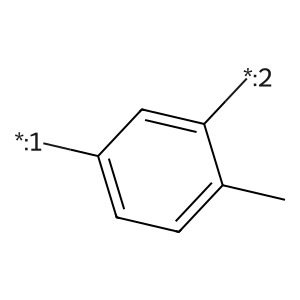

In [ ]:
Draw.MolToImage(Chem.MolFromSmiles("Cc1ccc([*:1])cc1[*:2]"))


Found 20 similar fragments with 3 attachment points:
1. Similarity: 0.412 | Attachments: 2 | Cc1c([*:1])cc(F)cc1[*:2]
2. Similarity: 0.400 | Attachments: 2 | Cc1cnc([*:1])cc1[*:2]
3. Similarity: 0.400 | Attachments: 2 | Cc1cc(F)c([*:1])cc1[*:2]
4. Similarity: 0.389 | Attachments: 2 | COc1ccc([*:1])cc1[*:2]
5. Similarity: 0.375 | Attachments: 2 | Fc1c([*:1])cccc1[*:2]
6. Similarity: 0.375 | Attachments: 2 | Clc1cc([*:1])cc([*:2])c1
7. Similarity: 0.368 | Attachments: 2 | Cc1c(F)cc([*:1])cc1[*:2]
8. Similarity: 0.364 | Attachments: 2 | COc1cc(C)c([*:1])cc1[*:2]
9. Similarity: 0.350 | Attachments: 2 | Cc1ncc([*:1])cc1[*:2]
10. Similarity: 0.333 | Attachments: 2 | CCOc1ccc([*:1])cc1[*:2]
11. Similarity: 0.320 | Attachments: 2 | Cc1cc([N+](=O)[O-])c([*:1])cc1[*:2]
12. Similarity: 0.316 | Attachments: 2 | OCc1c([*:1])cccc1[*:2]
13. Similarity: 0.300 | Attachments: 2 | Cc1sc([*:1])cc1[*:2]
14. Similarity: 0.280 | Attachments: 2 | Cc1nc2cc([*:1])cc([*:2])c2[nH]1
15. Similarity: 0.278 | Attach

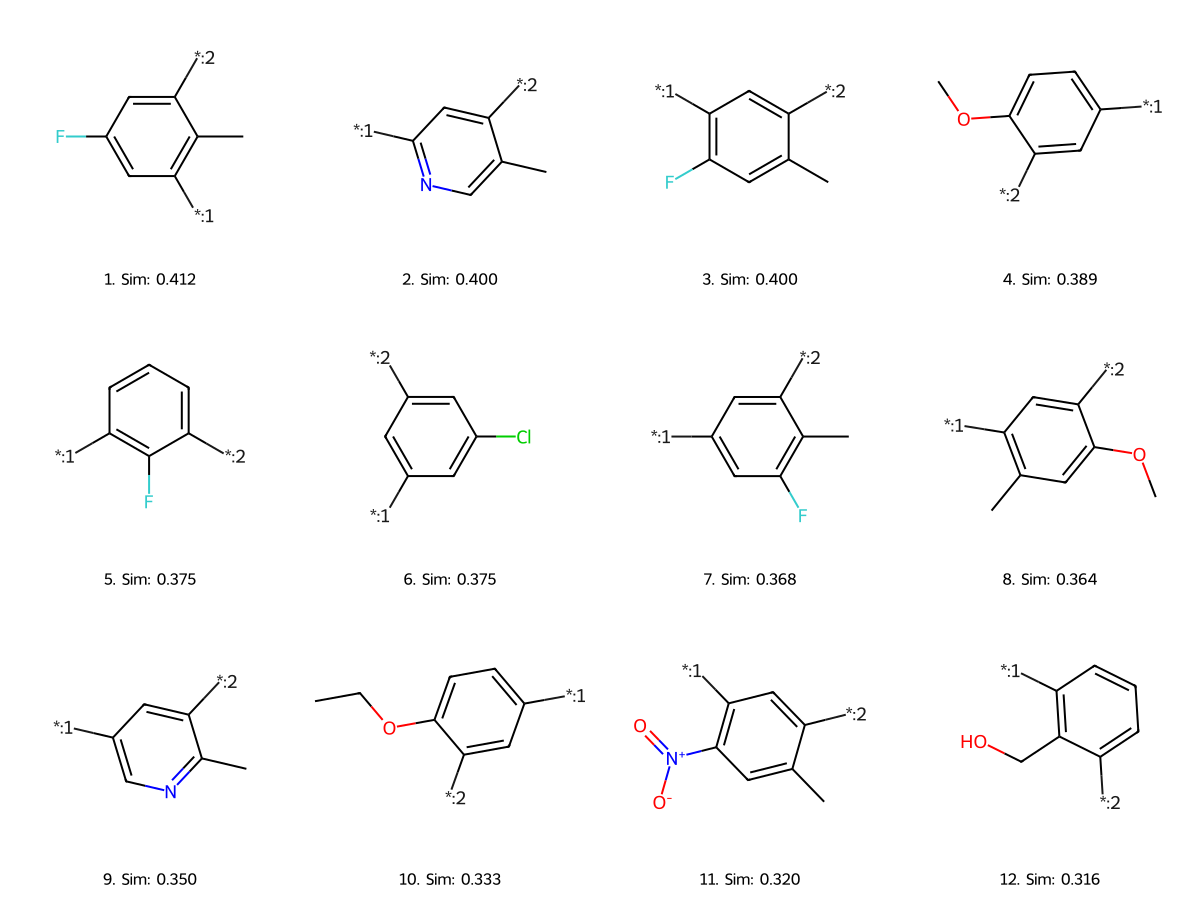

In [ ]:
ima_1 = find_similar_fragments(
    "Cc1ccc([*:1])cc1[*:2]", 
    "../data/kinase_inhibitors_fragments.txt",
    similarity_threshold=0.2,
    top_n=20
)

print(f"\nFound {len(ima_1)} similar fragments with 3 attachment points:")
print("=" * 80)
for i, (smiles, similarity, n_attach) in enumerate(ima_1, 1):
    print(f"{i}. Similarity: {similarity:.3f} | Attachments: {n_attach} | {smiles}")

# Visualize top results
if ima_1:
    print("\nVisualizing top similar fragments:")
    top_mols = [Chem.MolFromSmiles(smi) for smi, _, _ in ima_1[:12]]
    top_legends = [f"{i+1}. Sim: {sim:.3f}" for i, (_, sim, _) in enumerate(ima_1[:12])]
    
    grid = Draw.MolsToGridImage(
        top_mols,
        legends=top_legends,
        subImgSize=(300, 300),
        molsPerRow=4
    )

    display(grid)

In [ ]:
ima_1

[('Cc1c([*:1])cc(F)cc1[*:2]', 0.4117647058823529, 2),
 ('Cc1cnc([*:1])cc1[*:2]', 0.4, 2),
 ('Cc1cc(F)c([*:1])cc1[*:2]', 0.4, 2),
 ('COc1ccc([*:1])cc1[*:2]', 0.3888888888888889, 2),
 ('Fc1c([*:1])cccc1[*:2]', 0.375, 2),
 ('Clc1cc([*:1])cc([*:2])c1', 0.375, 2),
 ('Cc1c(F)cc([*:1])cc1[*:2]', 0.3684210526315789, 2),
 ('COc1cc(C)c([*:1])cc1[*:2]', 0.36363636363636365, 2),
 ('Cc1ncc([*:1])cc1[*:2]', 0.35, 2),
 ('CCOc1ccc([*:1])cc1[*:2]', 0.3333333333333333, 2),
 ('Cc1cc([N+](=O)[O-])c([*:1])cc1[*:2]', 0.32, 2),
 ('OCc1c([*:1])cccc1[*:2]', 0.3157894736842105, 2),
 ('Cc1sc([*:1])cc1[*:2]', 0.3, 2),
 ('Cc1nc2cc([*:1])cc([*:2])c2[nH]1', 0.28, 2),
 ('Cc1nc([*:1])cc([*:2])n1', 0.2777777777777778, 2),
 ('c1cc([*:1])cc([*:2])c1', 0.2727272727272727, 2),
 ('Cc1cnc([*:1])nc1[*:2]', 0.2631578947368421, 2),
 ('Cn1cc([*:1])cc([*:2])c1=O', 0.2608695652173913, 2),
 ('COc1cc([*:1])cc([*:2])c1Cl', 0.2608695652173913, 2),
 ('Cc1nc2c([*:1])cc([*:2])cn2c1C', 0.25925925925925924, 2)]

## Practice examples

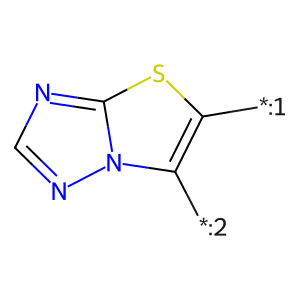

In [3]:
Draw.MolToImage(Chem.MolFromSmiles("[*:1]C1=C([*:2])N2N=CN=C2S1"))


Found 100 similar fragments
1. Similarity: 0.455 | Attachments: 2 | Cc1nc2sc([*:1])c([*:2])n2n1
2. Similarity: 0.417 | Attachments: 2 | C=Cc1nc2sc([*:1])c([*:2])n2n1
3. Similarity: 0.417 | Attachments: 2 | CCc1nc2sc([*:1])c([*:2])n2n1
4. Similarity: 0.406 | Attachments: 2 | c1nc2ncc([*:1])c([*:2])n2n1
5. Similarity: 0.394 | Attachments: 2 | c1nnc2sc([*:1])c([*:2])n12
6. Similarity: 0.394 | Attachments: 2 | c1nc2ccc([*:1])c([*:2])n2n1
7. Similarity: 0.364 | Attachments: 2 | c1nc2cc([*:1])c([*:2])cn2n1
8. Similarity: 0.361 | Attachments: 2 | Clc1nc2ncnn2c([*:1])c1[*:2]
9. Similarity: 0.361 | Attachments: 2 | Brc1nc2ncnn2c([*:1])c1[*:2]
10. Similarity: 0.361 | Attachments: 2 | Cc1nc2ncnn2c([*:1])c1[*:2]
11. Similarity: 0.353 | Attachments: 2 | c1nc2c([*:1])c([*:2])ccn2n1
12. Similarity: 0.333 | Attachments: 2 | Cc1cc(=O)n2c([*:1])c([*:2])sc2n1
13. Similarity: 0.333 | Attachments: 2 | Nc1ncnn2cc([*:1])c([*:2])c12
14. Similarity: 0.314 | Attachments: 2 | c1cn2c([*:1])c([*:2])nc2s1
15. Simi

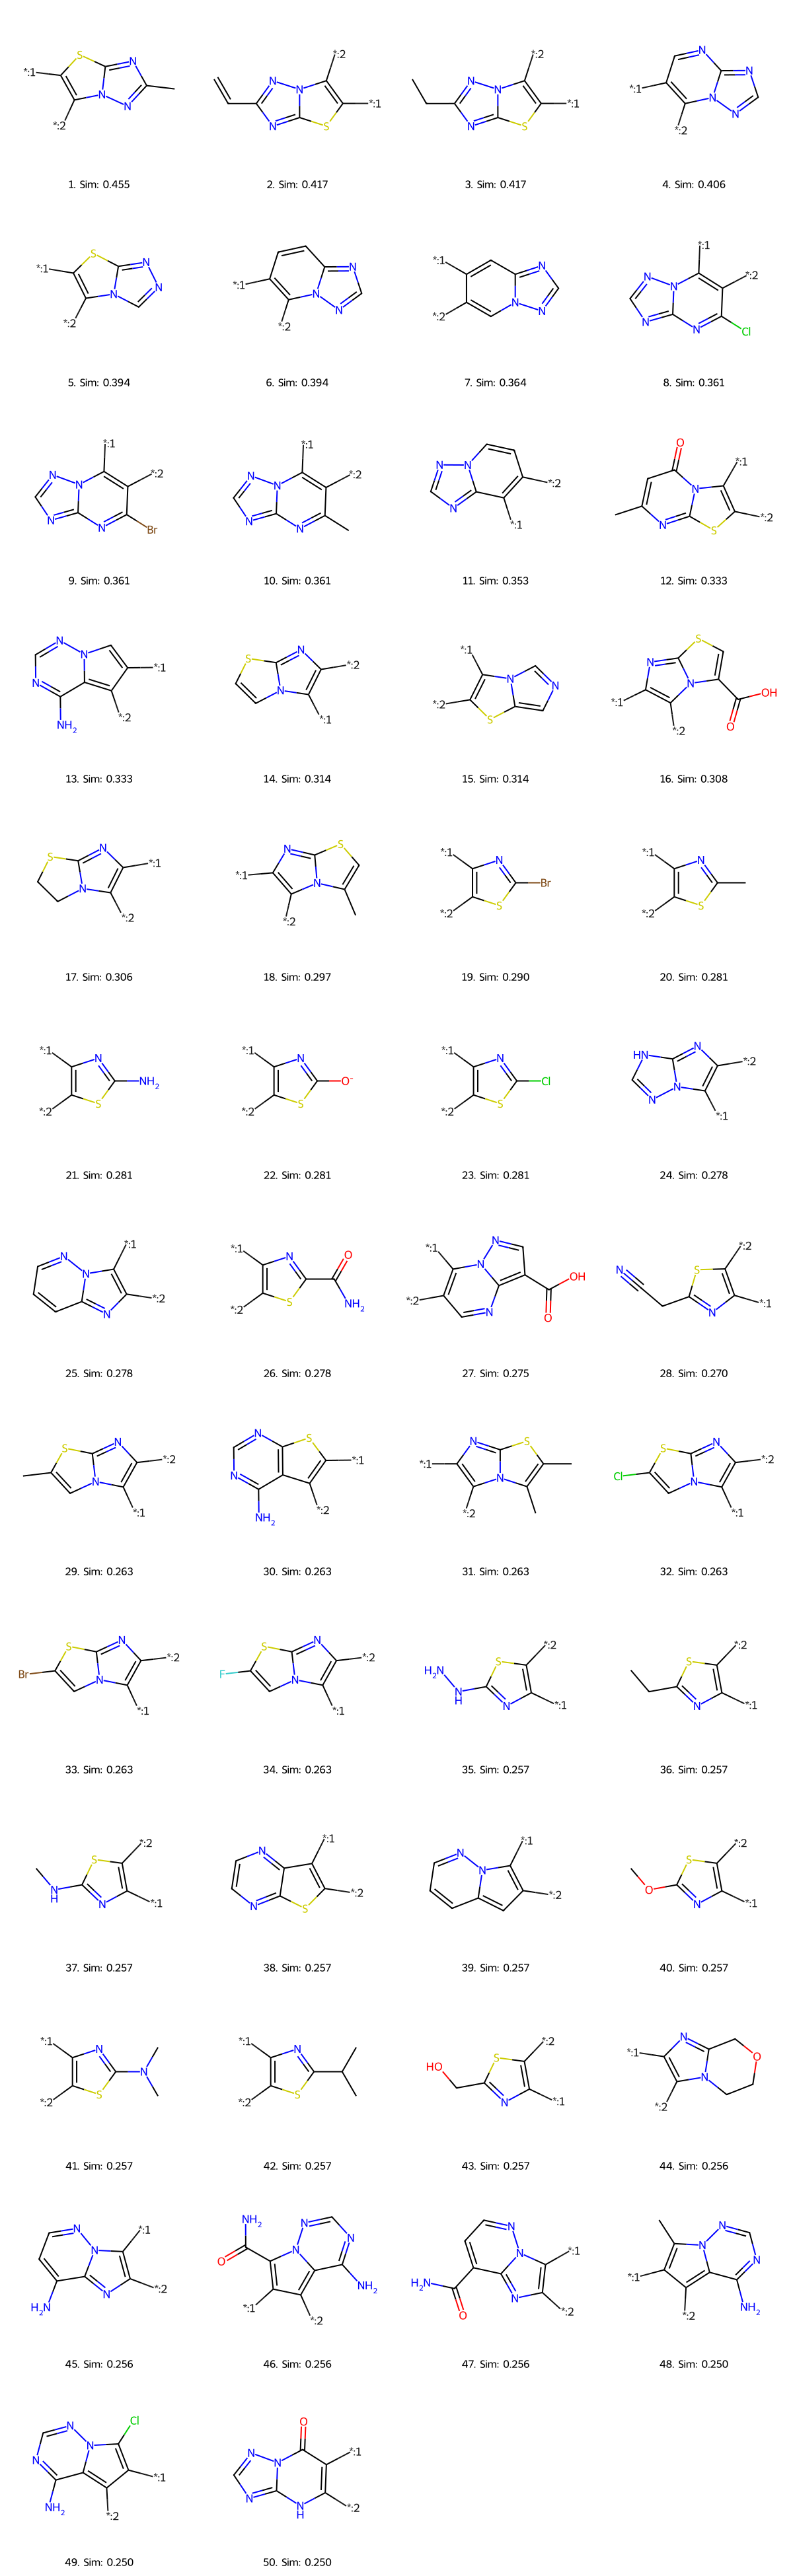

In [5]:
ibru = find_similar_fragments(
    "[*:1]C1=C([*:2])N2N=CN=C2S1", 
    "../data/fragments_cleaned_whole_filtered_chembl_with_smiles.txt.gz",
    similarity_threshold=0.2,
    top_n=100
)

print(f"\nFound {len(ibru)} similar fragments")
print("=" * 80)
for i, (smiles, similarity, n_attach) in enumerate(ibru, 1):
    print(f"{i}. Similarity: {similarity:.3f} | Attachments: {n_attach} | {smiles}")

# Visualize top results
if ibru:
    print("\nVisualizing top similar fragments:")
    top_mols = [Chem.MolFromSmiles(smi) for smi, _, _ in ibru[:50]]
    top_legends = [f"{i+1}. Sim: {sim:.3f}" for i, (_, sim, _) in enumerate(ibru[:50])]
    
    grid = Draw.MolsToGridImage(
        top_mols,
        legends=top_legends,
        subImgSize=(300, 300),
        molsPerRow=4
    )

    display(grid)

In [ ]:
acala = "Nc1nccn2c([*:1])nc([*:3])c12"
acala = find_similar_fragments(
    "Nc1nccn2c([*:1])nc([*:3])c12", 
    "../data/fragments_cleaned_whole_filtered_chembl_with_smiles.txt.gz",
    similarity_threshold=0.2,
    top_n=100
)

print(f"\nFound {len(acala)} similar fragments")
print("=" * 80)
for i, (smiles, similarity, n_attach) in enumerate(acala, 1):
    print(f"{i}. Similarity: {similarity:.3f} | Attachments: {n_attach} | {smiles}")

# Visualize top results
if acala:
    print("\nVisualizing top similar fragments:")
    top_mols = [Chem.MolFromSmiles(smi) for smi, _, _ in acala[:50]]
    top_legends = [f"{i+1}. Sim: {sim:.3f}" for i, (_, sim, _) in enumerate(acala[:50])]
    
    grid = Draw.MolsToGridImage(
        top_mols,
        legends=top_legends,
        subImgSize=(300, 300),
        molsPerRow=4
    )

    display(grid)

KeyboardInterrupt: 